# Dataset

Here we need to  predict the probability that an online transaction is fraudulent, as denoted by the binary target isFraud.


The data is broken into two files identity and transaction, which are joined by TransactionID. Not all transactions have corresponding identity information.

#### Transaction data 

* Transactionid: Id related to transaction
* TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
* TransactionAMT: transaction payment amount in USD
* ProductCD  [Categorical]: product code(the product for each transaction)
* card1 - 6 [Categorical]: payment card related information like card type, country etc
* addr1, addr2 [Categorical]: address information
* dist1,dist2: some distance information
* P_emaildomain [Categorical]: email domain of purchaser
* R_emaildomain [Categorical]: emaildomain of recipient
* C1-C14:  counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
* D1-D15: timedelta, such as days between previous transaction, etc.
* M1-M9 [Categorical]: match, such as names on card and address, etc.
* Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.



#### Identity data

* Transactionid: Id related to transaction
* DeviceType [Categorical]: Type of device used for transaction
* DeviceInfo [Categorical]: More information about device used
* id 1 - 38 [Categorical+numeric]: network connection information,browser information etc (id 12 - 38 are categorical information)

Note: Actually we dont have access to exact information about columns. Mostly it is beacuse of security purposes as we are handling transaction data.


# EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os,gc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score,roc_curve,auc,confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
import time
plt.style.use('seaborn-whitegrid')
import warnings
warnings.simplefilter("ignore")
colors = [x['color'] for x in plt.rcParams['axes.prop_cycle']]

In [2]:
df_train_transaction = pd.read_csv("train_transaction.csv")
df_test_transaction = pd.read_csv("test_transaction.csv")
df_train_identity = pd.read_csv("train_identity.csv")
df_test_identity = pd.read_csv("test_identity.csv")
df_sample_submission = pd.read_csv("sample_submission.csv")

In [7]:
# some columns (id) are wrongly labeled in test_identity. We will correct it
id_cols = [col for col in df_test_identity.columns if col[0]+col[1] == 'id']
rename_cols = {i:'id_'+str(i[-2]+i[-1]) for i in id_cols}
df_test_identity = df_test_identity.rename(columns=rename_cols)
 

In [8]:
print(df_train_transaction.shape)
print(df_test_transaction.shape)
print(df_train_identity.shape) 
print(df_test_identity.shape)  
print(df_sample_submission.shape) 

(590540, 394)
(506691, 393)
(144233, 41)
(141907, 41)
(506691, 2)


In [5]:
# df_train_transaction.head(3)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# df_train_identity.head(3)

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows


In [3]:
#combining frames

df_train_transaction = pd.read_csv('train_transaction.csv')
df_train_identity = pd.read_csv('train_identity.csv')
df_train = pd.merge(df_train_transaction, df_train_identity, how='left')


df_test_transaction = pd.read_csv('test_transaction.csv')
df_test_identity = pd.read_csv('test_identity.csv')

# some columns (id) are wrongly labeled in test_identity. We will correct it
id_cols = [col for col in df_test_identity.columns if col[0]+col[1] == 'id']
rename_cols = {i:'id_'+str(i[-2]+i[-1]) for i in id_cols}
df_test_identity = df_test_identity.rename(columns=rename_cols)
df_test = pd.merge(df_test_transaction, df_test_identity, how='left')

 
df_train.to_csv('C:\\Users\\rahul\\fraudulent transaction detection/train_combined.csv',index=False)
df_test.to_csv('C:\\Users\\rahul\\fraudulent transaction detection/test_combined.csv',index=False)

In [4]:
df_train = pd.read_csv('C:\\Users\\rahul\\fraudulent transaction detection/train_combined.csv')
df_test = pd.read_csv('C:\\Users\\rahul\\fraudulent transaction detection/test_combined.csv')
print(df_train.shape)
print(df_test.shape)

(590540, 434)
(506691, 433)


In [5]:
print(df_train.shape)
print(df_test.shape)

(590540, 434)
(506691, 433)


# Missing Values

In [6]:
def top_missing_cols(df,n=10,thresh=80):
    """
    returns missing columns in dataframe with missing values percent > thresh
    if n=None. It will gave whole dataframe with missing values percent > thresh
    """
    
    dff = (df.isnull().sum()/df.shape[0])*100
    dff = dff.reset_index()
    dff.columns = ['col','missing_percent']
    dff = dff.sort_values(by=['missing_percent'],ascending=False).reset_index(drop=True)
    print(f'There are {df.isnull().any().sum()} columns in this dataset with missing values.')
    print(f'There are {dff[dff["missing_percent"] > thresh].shape[0]} columns with missing percent values than {thresh}%')
    if n:
        return dff.head(n)
    else:
        return dff

In [7]:
top_missing_cols(df_train,thresh=90)

There are 414 columns in this dataset with missing values.
There are 12 columns with missing percent values than 90%


,col,missing_percent
0,id_24,99.196159
1,id_25,99.130965
2,id_07,99.127070
3,id_08,99.127070
4,id_21,99.126393
5,id_26,99.125715
6,id_27,99.124699
7,id_23,99.124699
8,id_22,99.124699
9,dist2,93.628374


In [8]:
top_missing_cols(df_test,thresh=90)

There are 385 columns in this dataset with missing values.
There are 10 columns with missing percent values than 90%


,col,missing_percent
0,id_24,99.064519
1,id_25,99.005508
2,id_26,99.003929
3,id_21,99.001561
4,id_08,99.001561
5,id_07,99.001561
6,id_27,99.000969
7,id_23,99.000969
8,id_22,99.000969
9,dist2,92.809030


In [9]:
cat_cols = ['ProductCD','card1','card2','card3','card4','card5','card6','P_emaildomain','R_emaildomain','M1',
'M2','M3','M4','M5','M6','M7','M8','M9','id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19',
'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29','addr1','addr2',
'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']

for col in cat_cols:
    df = pd.concat([df_train[col],df_test[col]],axis=0)
    sh = df.value_counts().shape[0]
    missing = round((df.isnull().sum()/df.shape[0])*100,2)
    print(f'No of unique values in {col} is {sh} | missing percent is {missing}%')

No of unique values in ProductCD is 5 | missing percent is 0.0%
No of unique values in card1 is 17091 | missing percent is 0.0%
No of unique values in card2 is 501 | missing percent is 1.6%
No of unique values in card3 is 133 | missing percent is 0.42%
No of unique values in card4 is 4 | missing percent is 0.42%
No of unique values in card5 is 138 | missing percent is 0.8%
No of unique values in card6 is 4 | missing percent is 0.42%
No of unique values in P_emaildomain is 60 | missing percent is 14.91%
No of unique values in R_emaildomain is 60 | missing percent is 75.1%
No of unique values in M1 is 2 | missing percent is 40.81%
No of unique values in M2 is 2 | missing percent is 40.81%
No of unique values in M3 is 2 | missing percent is 40.81%
No of unique values in M4 is 3 | missing percent is 47.32%
No of unique values in M5 is 2 | missing percent is 60.16%
No of unique values in M6 is 2 | missing percent is 29.92%
No of unique values in M7 is 2 | missing percent is 52.98%
No of uni

In [10]:
df_train['isFraud'].value_counts()

0    569877
1     20663
Name: isFraud, dtype: int64

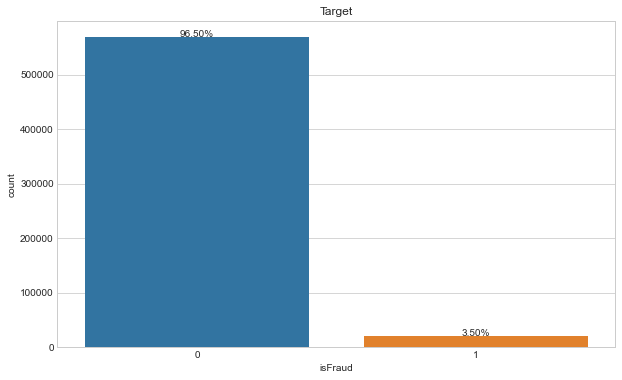

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(10,6))
sns.countplot(df_train['isFraud'])
axes.title.set_text('Target')
total = float(df_train['isFraud'].shape[0])  
for p in axes.patches:
    height = p.get_height()
    axes.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height*100/total),
            ha="center") 
plt.show()


# CHECKING OUTLIERS


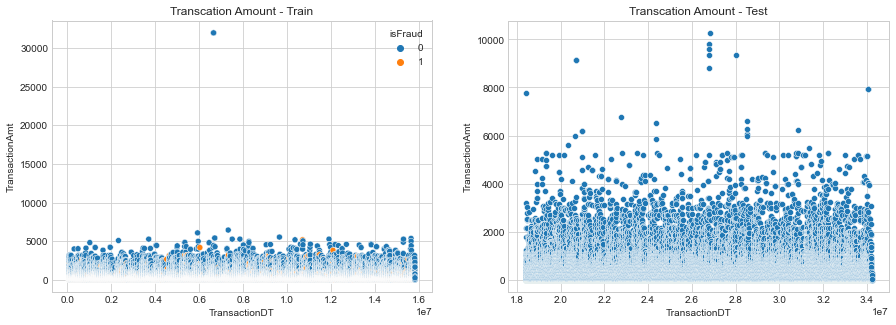

In [12]:
fig, axes = plt.subplots(1,2,figsize=(15,5))

sns.scatterplot(y=df_train['TransactionAmt'],x=df_train['TransactionDT'],hue=df_train['isFraud'],ax=axes[0])
axes[0].title.set_text('Transcation Amount - Train')

sns.scatterplot(y=df_test['TransactionAmt'],x=df_test['TransactionDT'],ax=axes[1])
axes[1].title.set_text('Transcation Amount - Test')

plt.show()

In [13]:
df_train = df_train[df_train['TransactionAmt'] < 30000]
df_train.shape

(590538, 434)

## Distribution

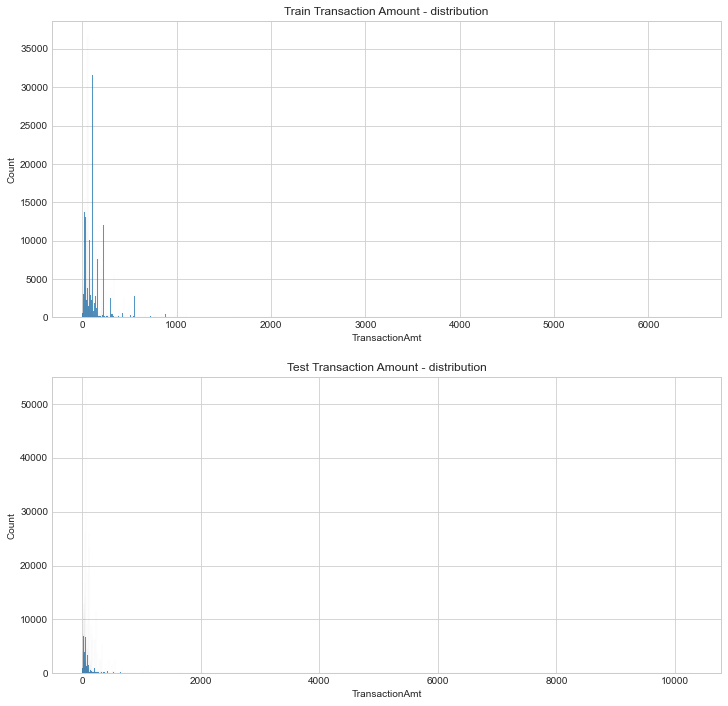

In train data Minimum transaction amount is 0.251 and maximum amount  is 6450.97
In test data Minimum transaction amount is 0.018000000000000002 and maximum amount  is 10270.0


In [14]:
fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(12,12))
sns.histplot(df_train['TransactionAmt'],ax=axes[0])
sns.histplot(df_test['TransactionAmt'],ax=axes[1])
axes[0].title.set_text('Train Transaction Amount - distribution')
axes[1].title.set_text('Test Transaction Amount - distribution')
plt.show()

print(f'In train data Minimum transaction amount is {df_train["TransactionAmt"].min()} and maximum amount  is {df_train["TransactionAmt"].max()}')
print(f'In test data Minimum transaction amount is {df_test["TransactionAmt"].min()} and maximum amount  is {df_test["TransactionAmt"].max()}')

## TransactionAmt vs Fraud

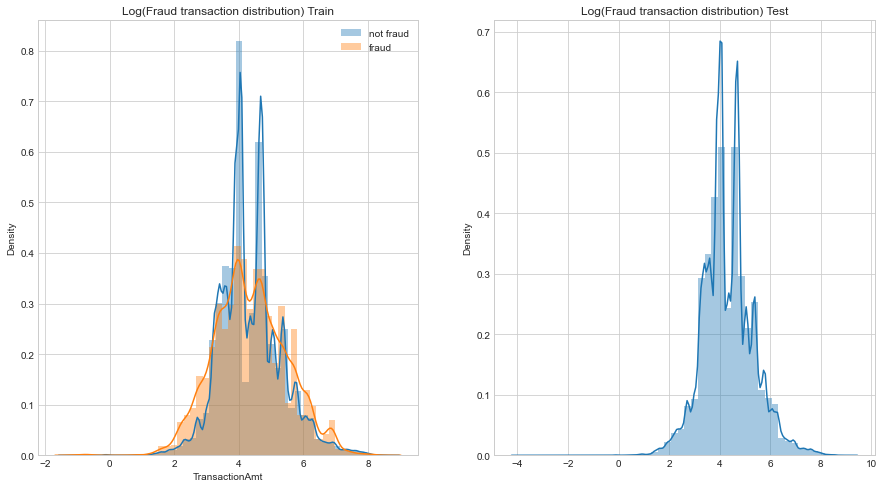

In [15]:
test_amt = np.log(df_test[['TransactionAmt']])

dff_fraud = df_train[df_train['isFraud'] == 1]
dff_notfraud = df_train[df_train['isFraud'] == 0]

dff_fraud['TransactionAmt'] = np.log(dff_fraud['TransactionAmt'])
dff_notfraud['TransactionAmt'] = np.log(dff_notfraud['TransactionAmt'])


fig,axes = plt.subplots(1,2,figsize=(15,8))
sns.distplot(dff_notfraud['TransactionAmt'],ax=axes[0],label='not fraud')
sns.distplot(dff_fraud['TransactionAmt'],ax=axes[0],label='fraud')
axes[0].title.set_text('Log(Fraud transaction distribution) Train')
axes[0].legend()

sns.distplot(test_amt,ax=axes[1])
axes[1].title.set_text('Log(Fraud transaction distribution) Test')
plt.show()

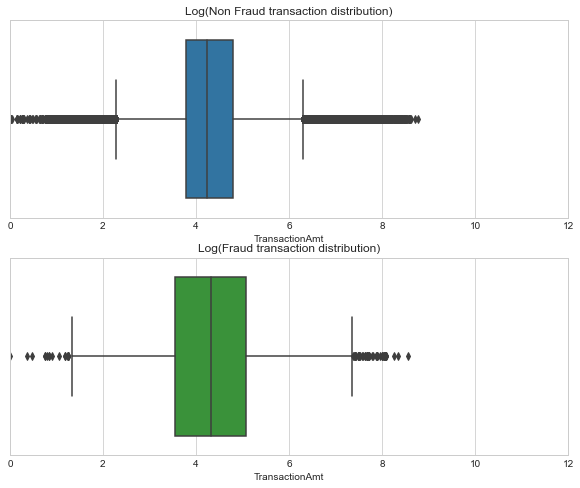

Mean transaction amt for fraud is 4.3506 ie, 77.5264 dollars
Mean transaction amt for non-fraud is 4.3643 ie, 78.5962 dollars
Median transaction amt for fraud is 4.3175  ie, 75.0000 dollars
Median transaction amt for non-fraud is 4.2268  ie, 68.5000 dollars


In [16]:
fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(10,8))
sns.boxplot(dff_notfraud['TransactionAmt'],ax=axes[0])
axes[0].title.set_text('Log(Non Fraud transaction distribution)')
axes[0].set(xlim=(0, 12))
sns.boxplot(dff_fraud['TransactionAmt'],ax=axes[1],color=colors[2])
axes[1].title.set_text('Log(Fraud transaction distribution)')
axes[1].set(xlim=(0, 12))
plt.show()

print('Mean transaction amt for fraud is {:.4f} ie, {:.4f} dollars'.format(dff_fraud['TransactionAmt'].mean(),np.exp(dff_fraud['TransactionAmt'].mean())))
print('Mean transaction amt for non-fraud is {:.4f} ie, {:.4f} dollars'.format(dff_notfraud['TransactionAmt'].mean(),np.exp(dff_notfraud['TransactionAmt'].mean())))

print('Median transaction amt for fraud is {:.4f}  ie, {:.4f} dollars'.format(dff_fraud['TransactionAmt'].median(),np.exp(dff_fraud['TransactionAmt'].median())))
print('Median transaction amt for non-fraud is {:.4f}  ie, {:.4f} dollars'.format(dff_notfraud['TransactionAmt'].median(),np.exp(dff_notfraud['TransactionAmt'].median())))

### * Fraudulant transactions have slightly higher median.
* Also in Fradulant transactions we have a better normal distribution which is wide at bell curve. It indicates more transactions are present at a particlar intreval which are fraudulant.
* It seems that the transactions with 'LogTransactionAmt' larger than 5.5 (244 dollars) and smaller than 3.3 (27 dollars) have a higher frequency and probability density of being fraudulent. On the other hand, the ones with 'LogTransactionAmt' from 3.3 to 5.5 have a higher chance of being legit.

## ProductCD

In [17]:
df_train['ProductCD'].isnull().sum()

0

In [18]:
df_train['ProductCD'].value_counts()

W    439668
C     68519
R     37699
H     33024
S     11628
Name: ProductCD, dtype: int64

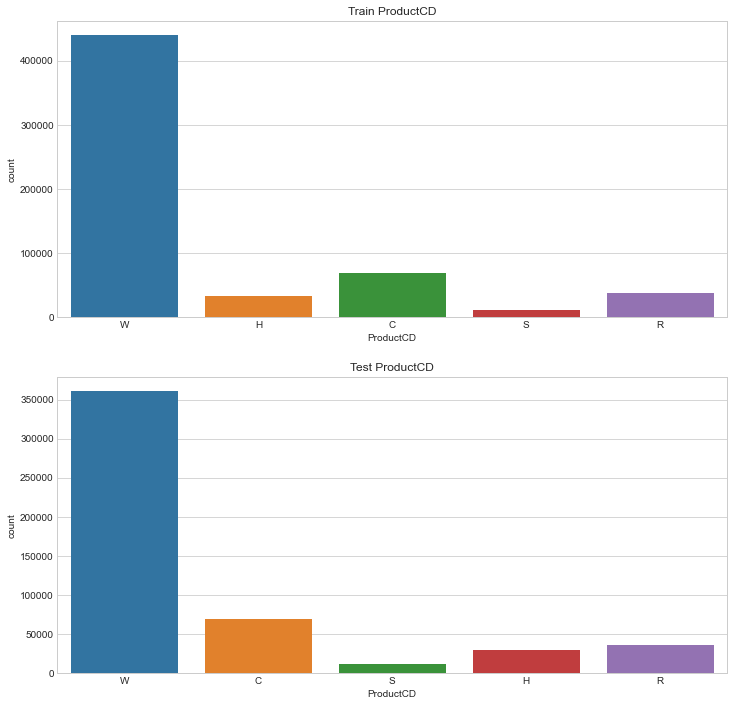

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(12,12))
sns.countplot(df_train['ProductCD'],ax=axes[0])
sns.countplot(df_test['ProductCD'],ax=axes[1])
axes[0].title.set_text('Train ProductCD')
axes[1].title.set_text('Test ProductCD')
plt.show()

In [20]:
def hor_plot(feat,df=df_train,label_rotation=False,shape=(12,8)):
    
    val_cnts = df[feat].value_counts()
    df1 = pd.DataFrame({feat: val_cnts.index,'Number of units': val_cnts.values})
    # Calculate the percentage of target=1 per category value.For that what we did is we took the mean value of TARGET
    percent = df[[feat, 'isFraud']].groupby([feat],as_index=False).mean()
    percent.sort_values(by='isFraud', ascending=False, inplace=True)
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=shape)
    s = sns.barplot(ax=ax1, x = feat, y="Number of units",data=df1)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    
    s = sns.barplot(ax=ax2, x = feat, y='isFraud', order=percent[feat], data=percent)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    
    plt.ylabel('Percent of Fraud transactions [Target with value 1]', fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.show();


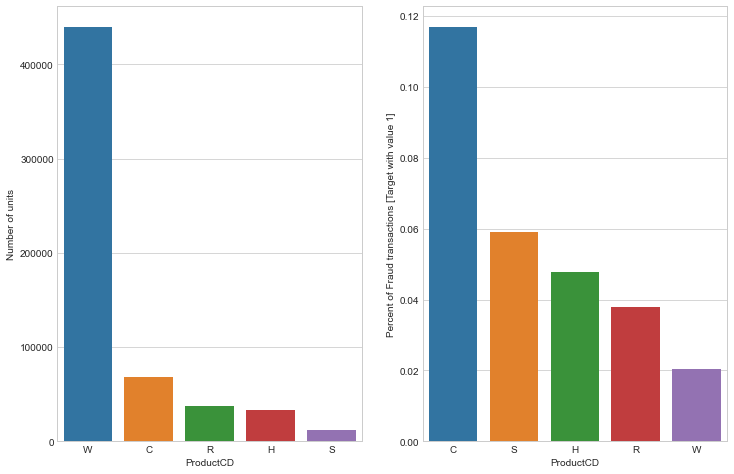

In [21]:
hor_plot(df=df_train,feat='ProductCD')

### 
* We can see that Product W is present most among all transactions. In fraud transactions also the count of product W is more. But only about 2% of all Product W transaction is fraud.
* About 11.5% of all ProductC are fraudulant trnasactions
* Also about 6% of all ProductS transactions are fraud.

## Card 1 - 6
It has payment card related information like card type, country etc. It is given that these features are categorical. 

In [22]:
cards = [col for col in df_train.columns if 'card' in col]
df_train[cards].head()

,card1,card2,card3,card4,card5,card6
0,13926,NaN,150.0,discover,142.0,credit
1,2755,404.0,150.0,mastercard,102.0,credit
2,4663,490.0,150.0,visa,166.0,debit
3,18132,567.0,150.0,mastercard,117.0,debit
4,4497,514.0,150.0,mastercard,102.0,credit


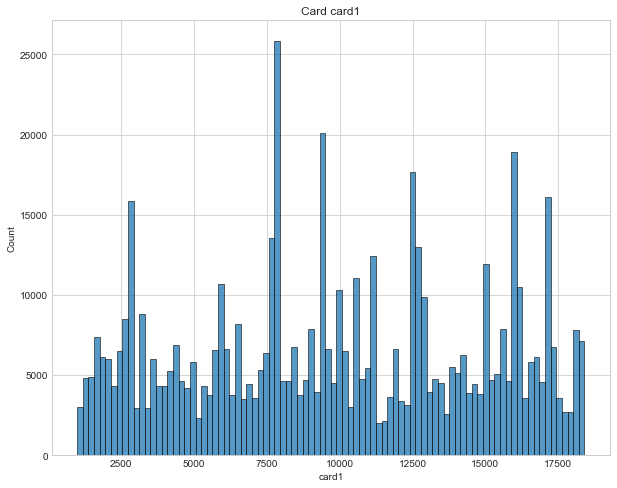

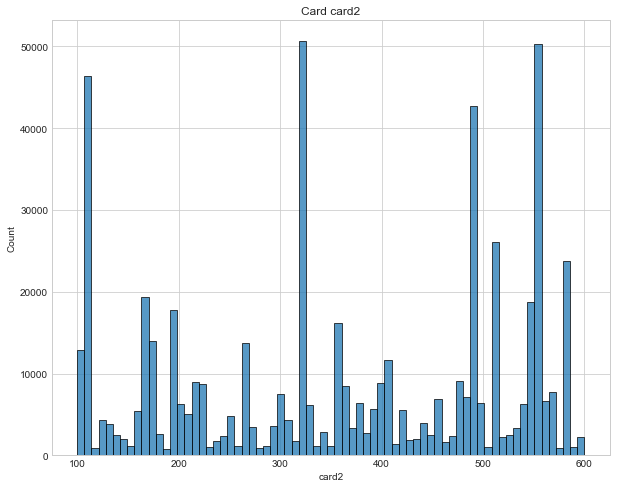

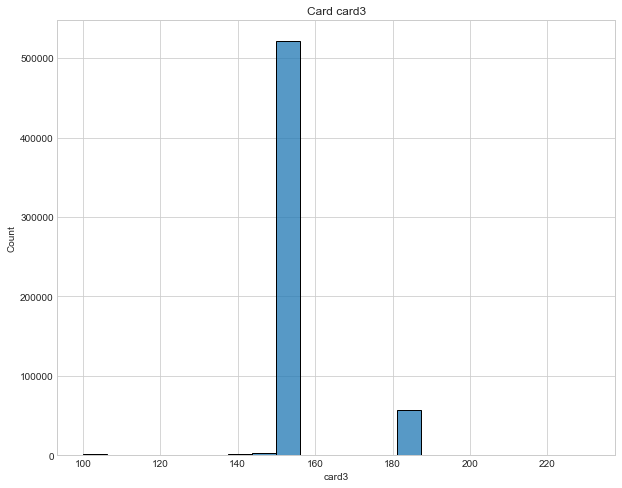

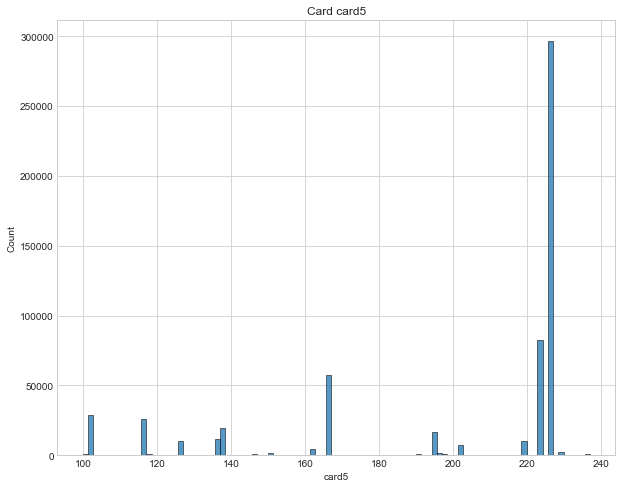

In [23]:
for c in cards:
    if df_train[c].dtypes in ['int64','float64']:
        fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(10,8))
        sns.histplot(df_train[c])
        axes.title.set_text(f'Card {c}')
        plt.show()
    

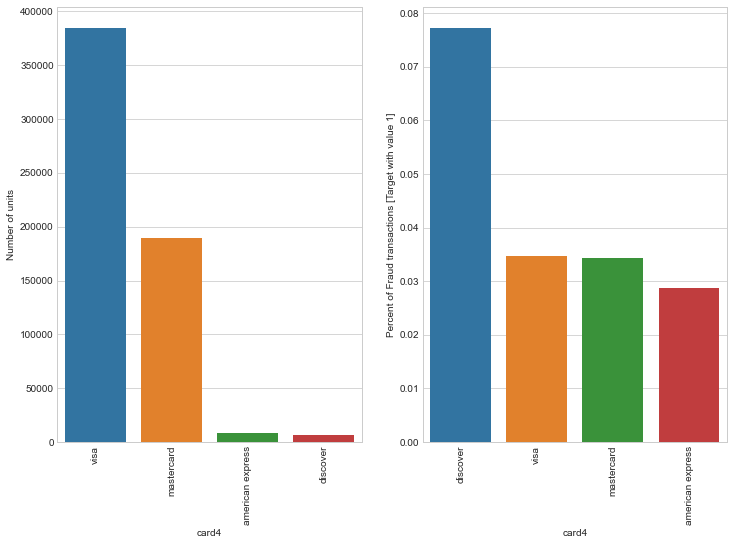

In [24]:
hor_plot('card4',label_rotation=True)

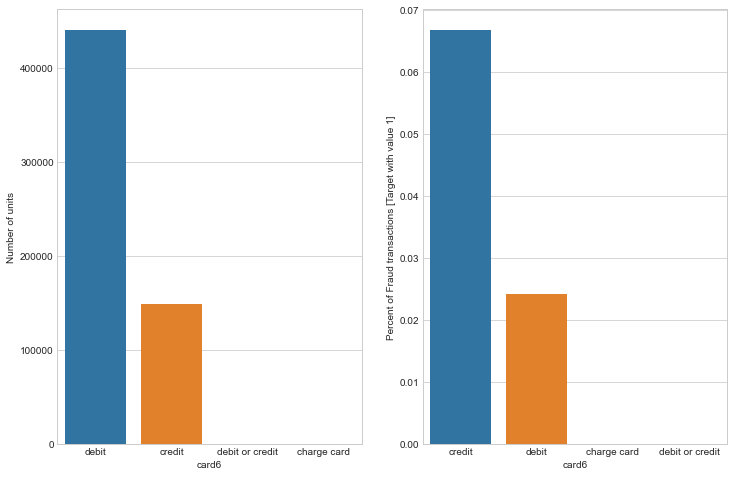

In [25]:
hor_plot('card6')

In [26]:
cards = ['card1','card2','card3','card4','card5','card6','isFraud']
df_train[cards].corr()

,card1,card2,card3,card5,isFraud
card1,1.000000,0.004956,0.002966,-0.093624,-0.013639
card2,0.004956,1.000000,0.023817,0.030494,0.003389
card3,0.002966,0.023817,1.000000,-0.158387,0.154151
card5,-0.093624,0.030494,-0.158387,1.000000,-0.033581
isFraud,-0.013639,0.003389,0.154151,-0.033581,1.000000


## 
* We can see that for card1 and card2 we have lot of categorical values.It behaves like numeric features.
* We can see that among credit card there is more chance to have fraud transactions. It is about 6.5% of all transactions.
* Also among card4 discover card have a highest fraudelent cases of about 7.6%
* card3 has low coorelation with other card features.

## ## P_email domain and R_email domain

Email domain of purchaser and email domain of recipiant

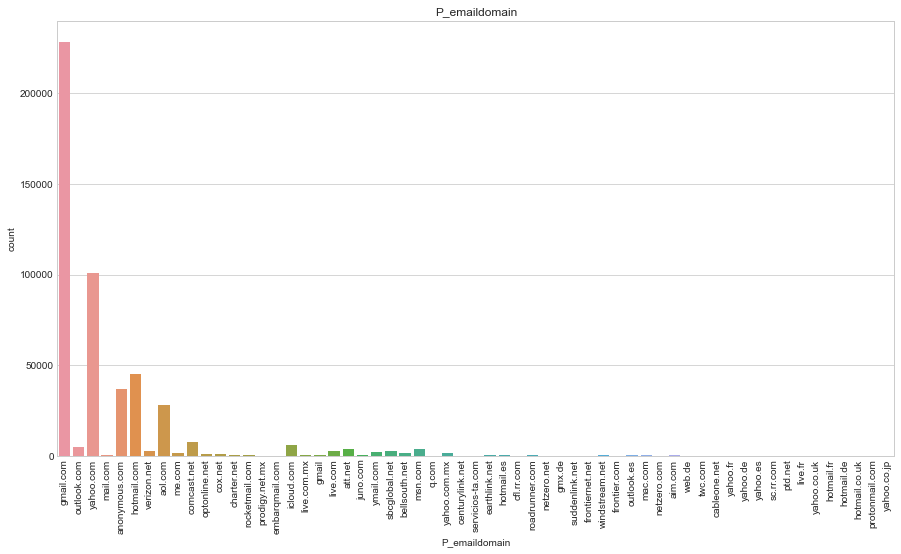

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(15,8))
sns.countplot(df_train_transaction['P_emaildomain'])
axes.title.set_text('P_emaildomain')
axes.set_xticklabels(axes.get_xticklabels(),rotation=90)
plt.show()

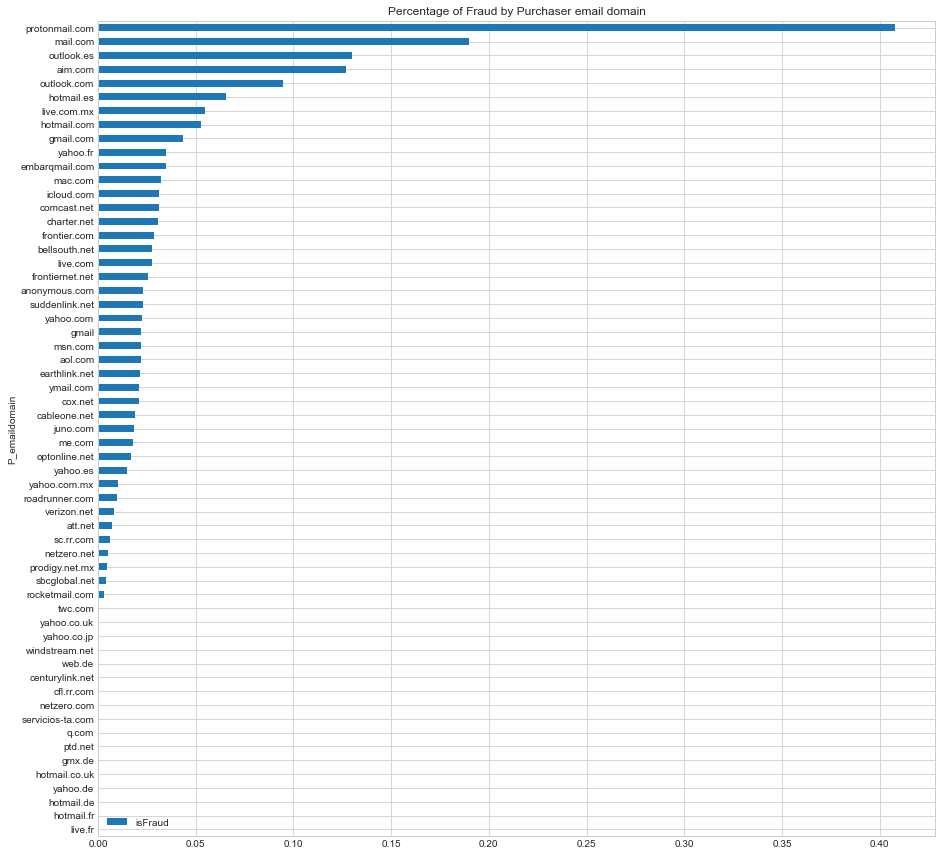

In [28]:
df_train_transaction[['P_emaildomain','isFraud']].groupby(by=['P_emaildomain']).mean() \
        .sort_values(by=['isFraud']).plot(kind='barh',
        figsize=(15, 15),
         title='Percentage of Fraud by Purchaser email domain')
plt.show()


## 
* In purchaser email domains most mails are from gmail.com
* Among those More fraud transaction comes from domain protonmail.com which is more than 40%.

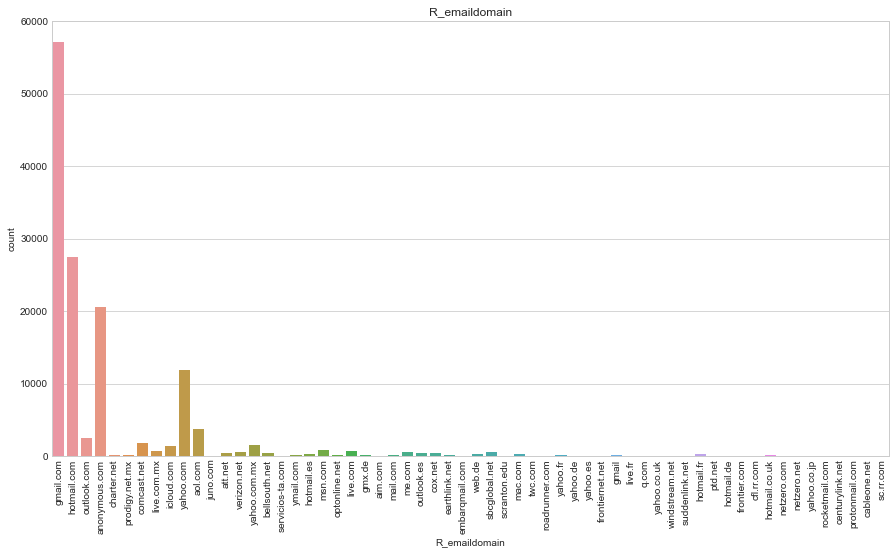

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(15,8))
sns.countplot(df_train_transaction['R_emaildomain'])
axes.title.set_text('R_emaildomain')
axes.set_xticklabels(axes.get_xticklabels(),rotation=90)
plt.show()

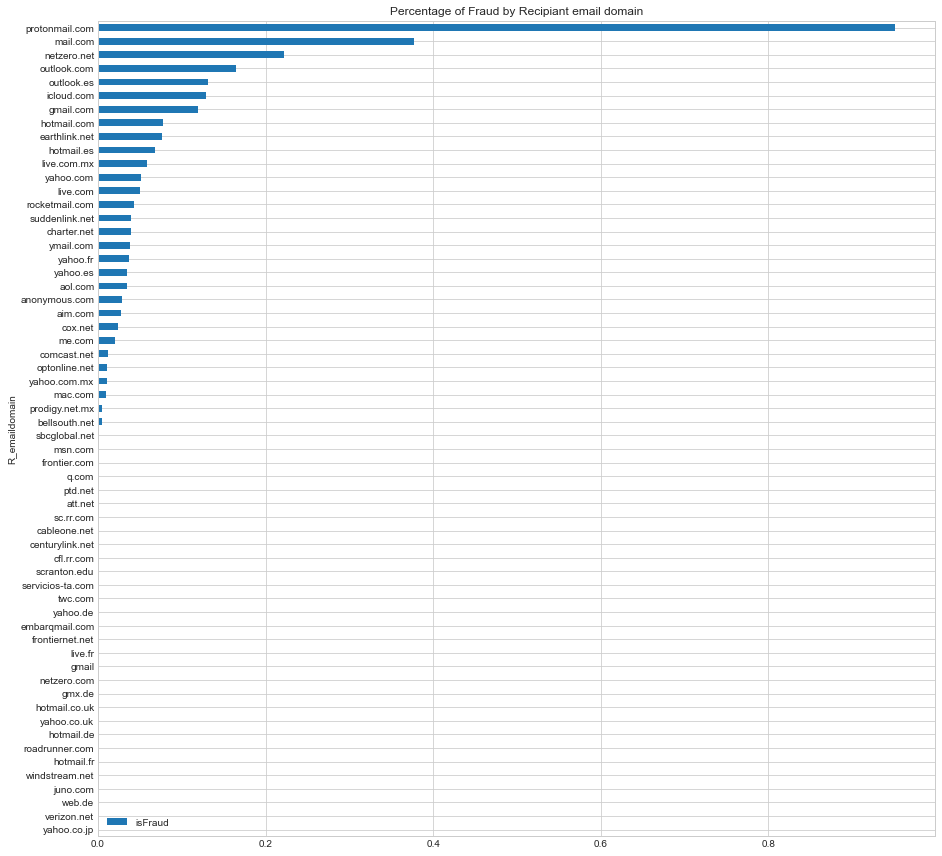

In [30]:
df_train_transaction[['R_emaildomain','isFraud']].groupby(by=['R_emaildomain']).mean() \
        .sort_values(by=['isFraud']).plot(kind='barh',
        figsize=(15, 15),
         title='Percentage of Fraud by Recipiant email domain')
plt.show()

### 
* In purchaser email domains most mails are from gmail.com
* Among those More fraud transaction comes from domain protonmail.com which is more than 90% which is a serious issue.

## Adddr1 and Addr2

This is some categorical data giving address information 

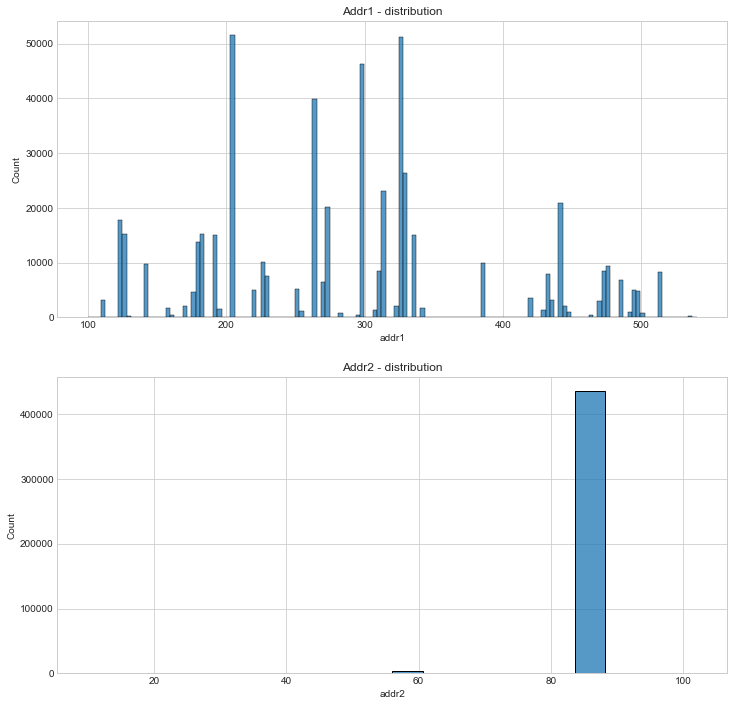

In [31]:
fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(12,12))
sns.histplot(df_train_transaction['addr1'],ax=axes[0])
sns.histplot(df_test_transaction['addr2'],ax=axes[1])
axes[0].title.set_text('Addr1 - distribution')
axes[1].title.set_text('Addr2 - distribution')
plt.show()

## Dist1 and Dist2
This might indicate the distance between transaction location and card owner address.This is just my assumption.

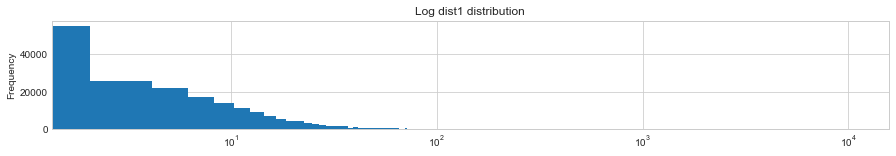

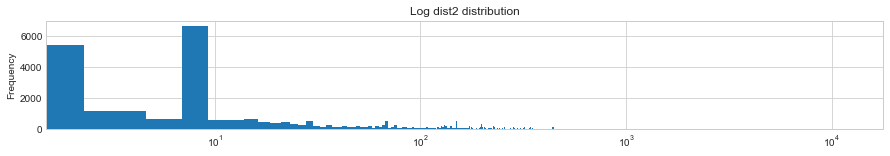

In [32]:
df_train['dist1'].plot(kind='hist',
                                bins=5000,
                                figsize=(15, 2),
                                title='Log dist1 distribution',
                                color=colors[0],
                                logx=True)
plt.show()
df_train['dist2'].plot(kind='hist',
                                bins=5000,
                                figsize=(15, 2),
                                title='Log dist2 distribution',
                                color=colors[0],
                                logx=True)
plt.show()

##  C1-C14

In [33]:
c_cols = [c for c in df_train if c[0] == 'C']
df_train[c_cols].head()

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0
1,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
2,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
3,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0
4,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0


In [34]:
# Sample 500 fraud and 500 non-fraud examples to plot
sample_df = pd.concat([df_train.loc[df_train['isFraud'] == 0].sample(500),
                       df_train.loc[df_train['isFraud'] == 1].sample(500)])

<Figure size 1440x1440 with 0 Axes>

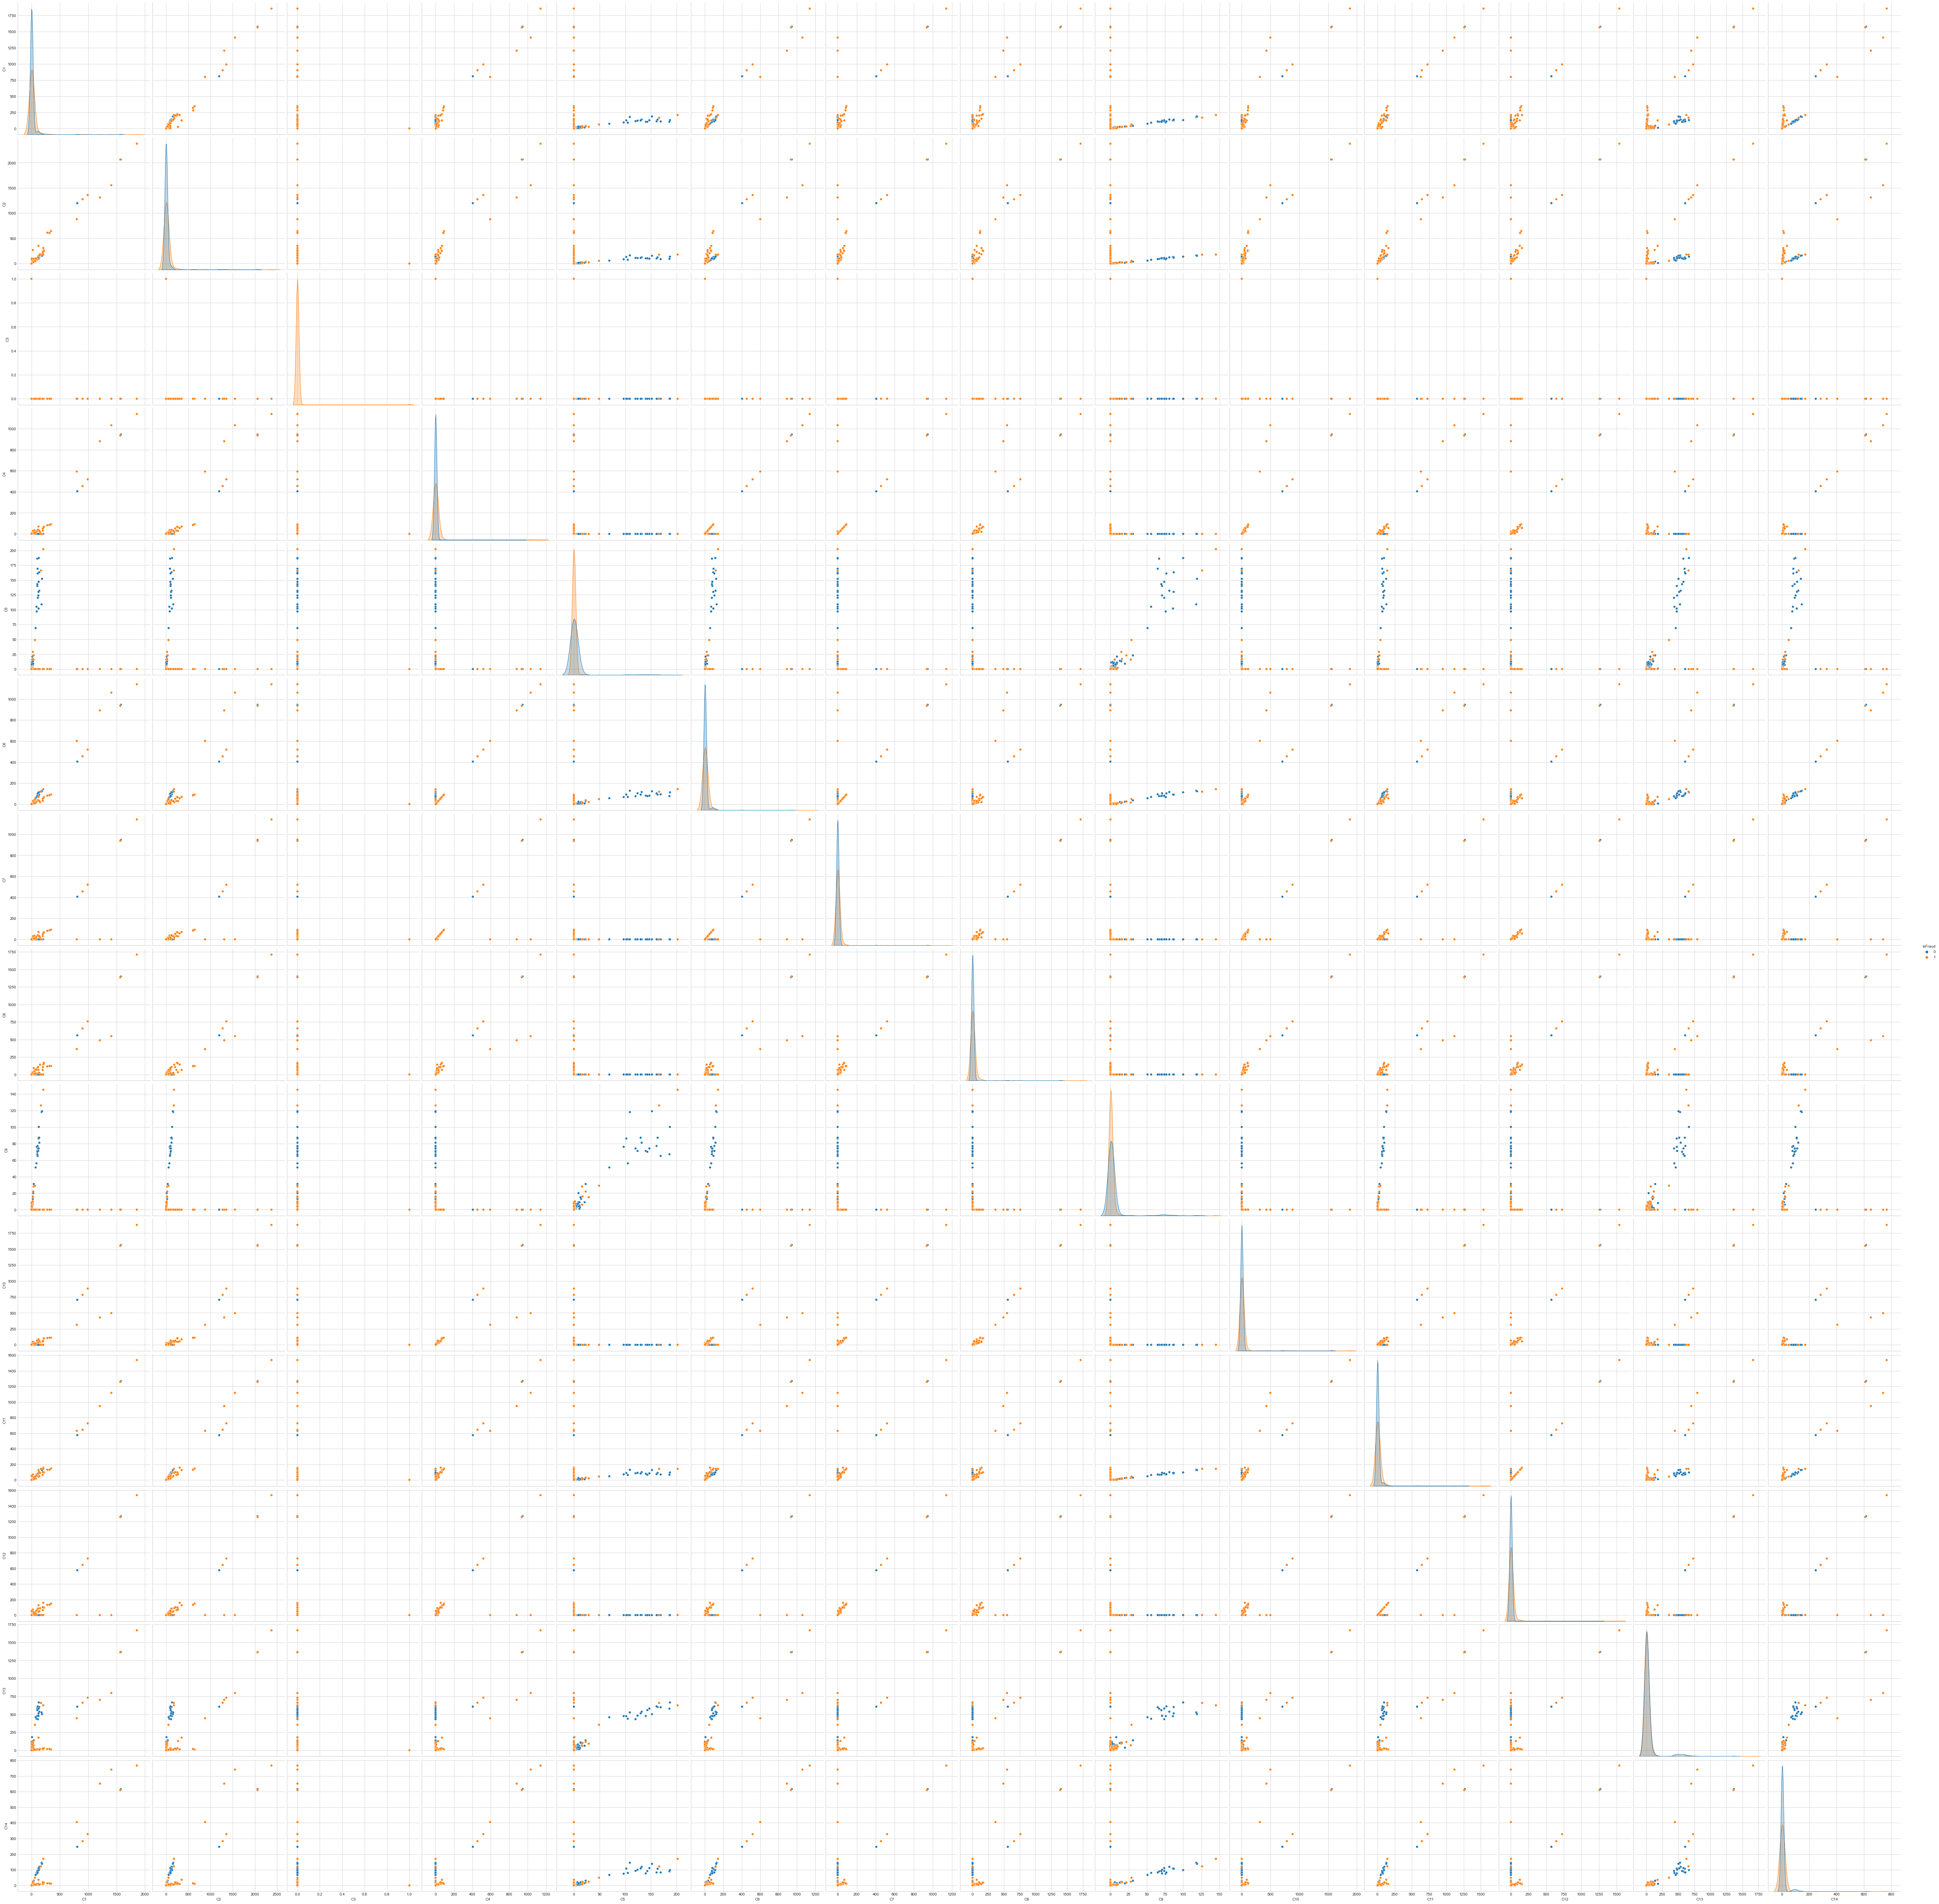

In [35]:
plt.figure(figsize=(20,20))
sns.pairplot(sample_df, 
             hue='isFraud',
            vars=c_cols,height=5)
plt.show()

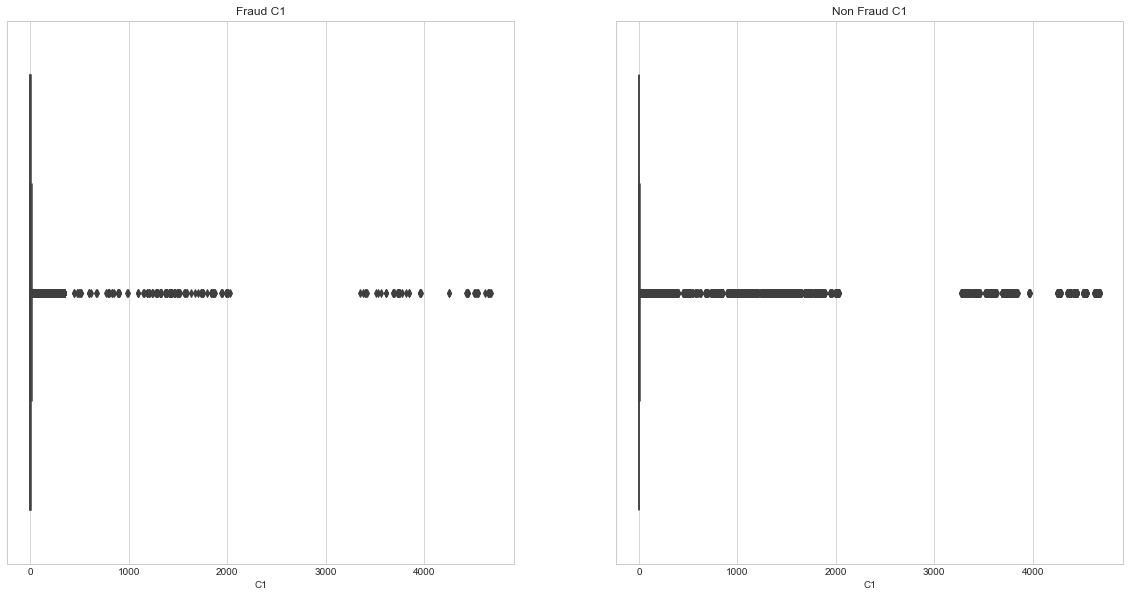

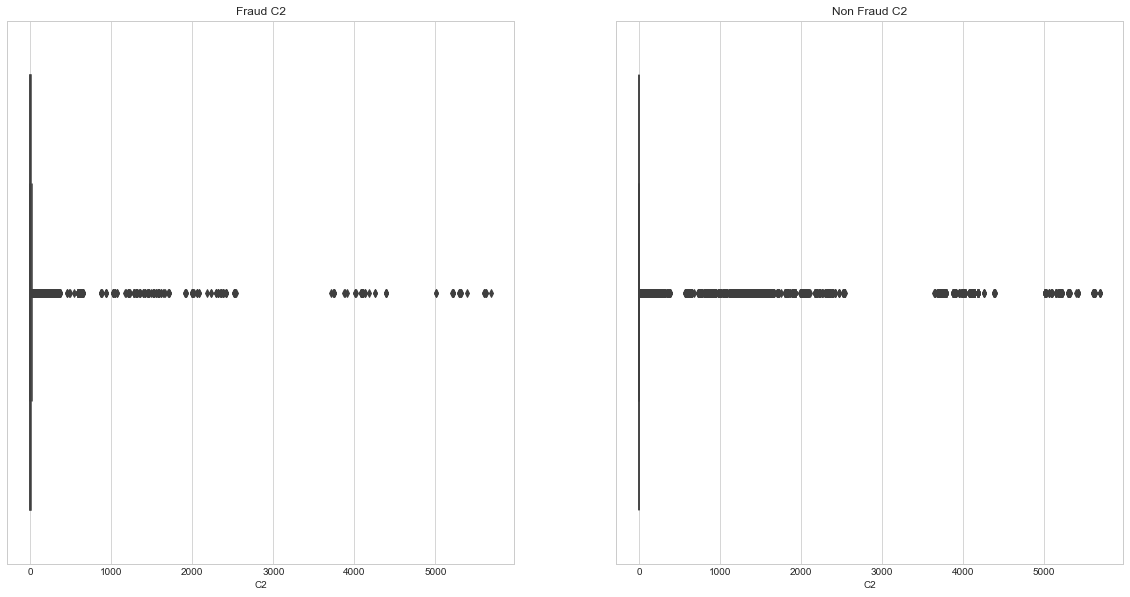

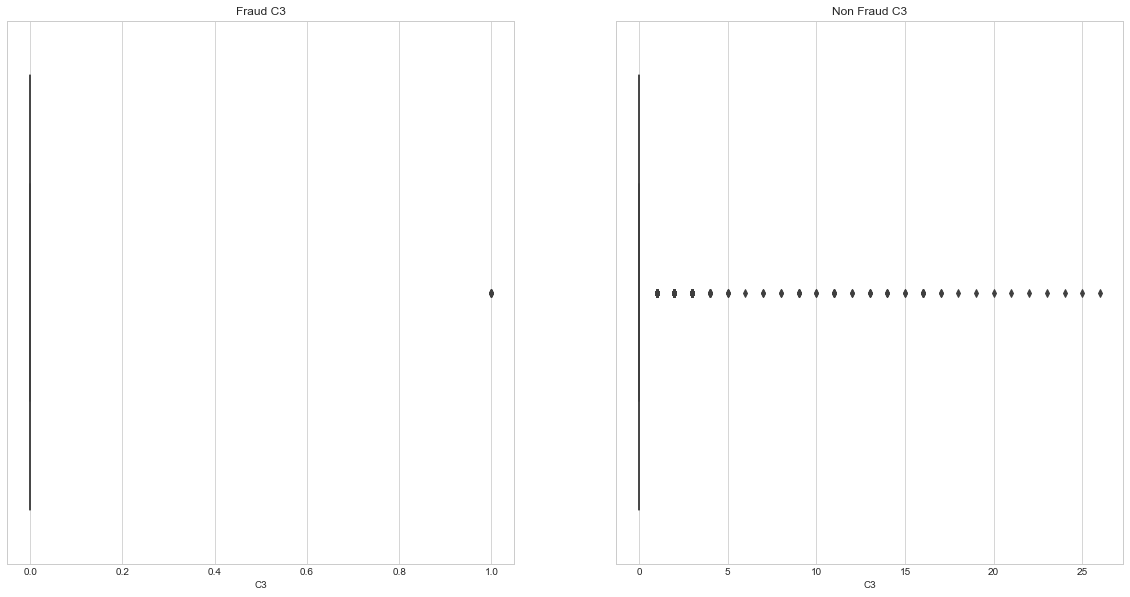

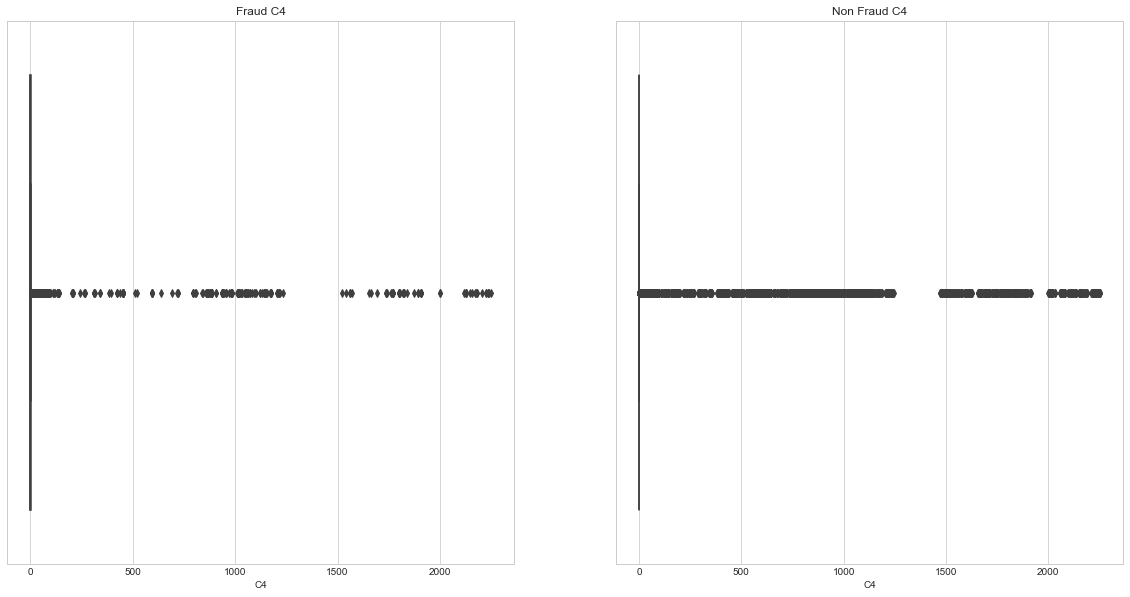

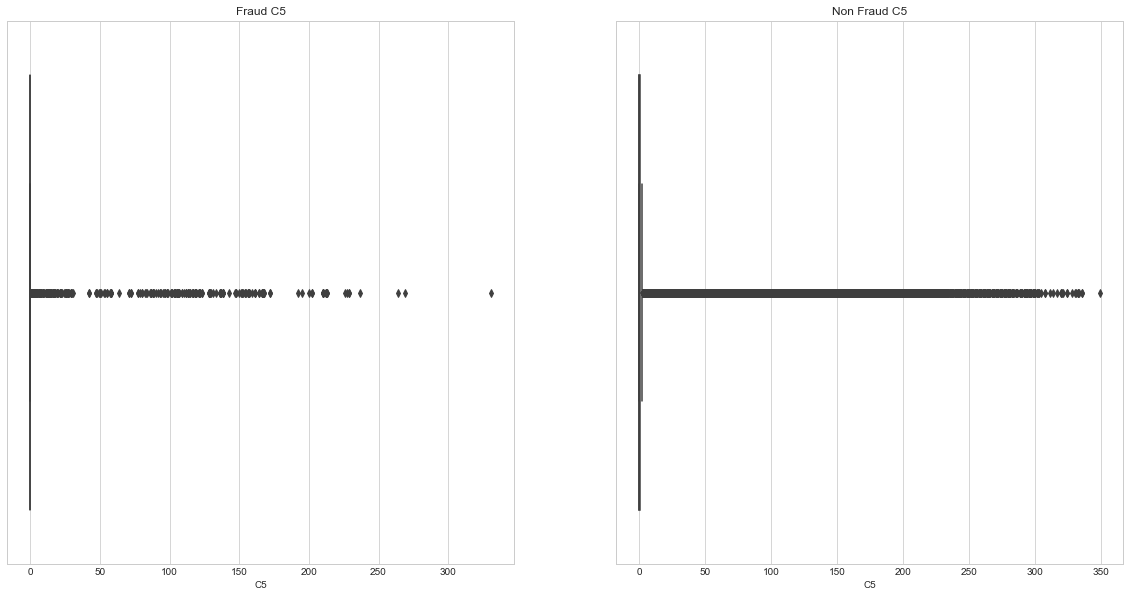

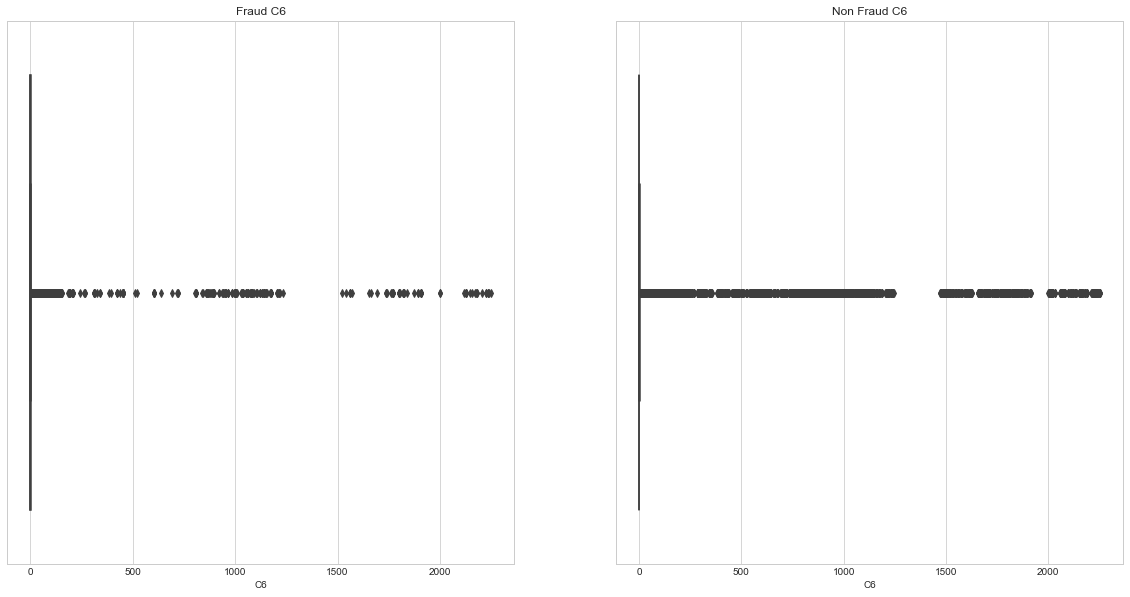

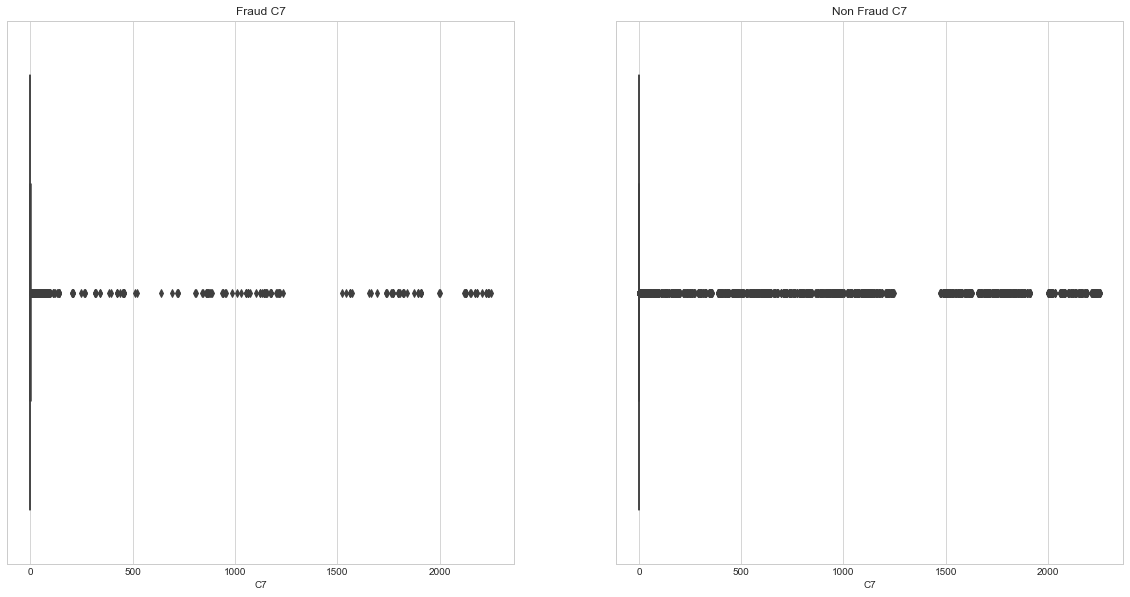

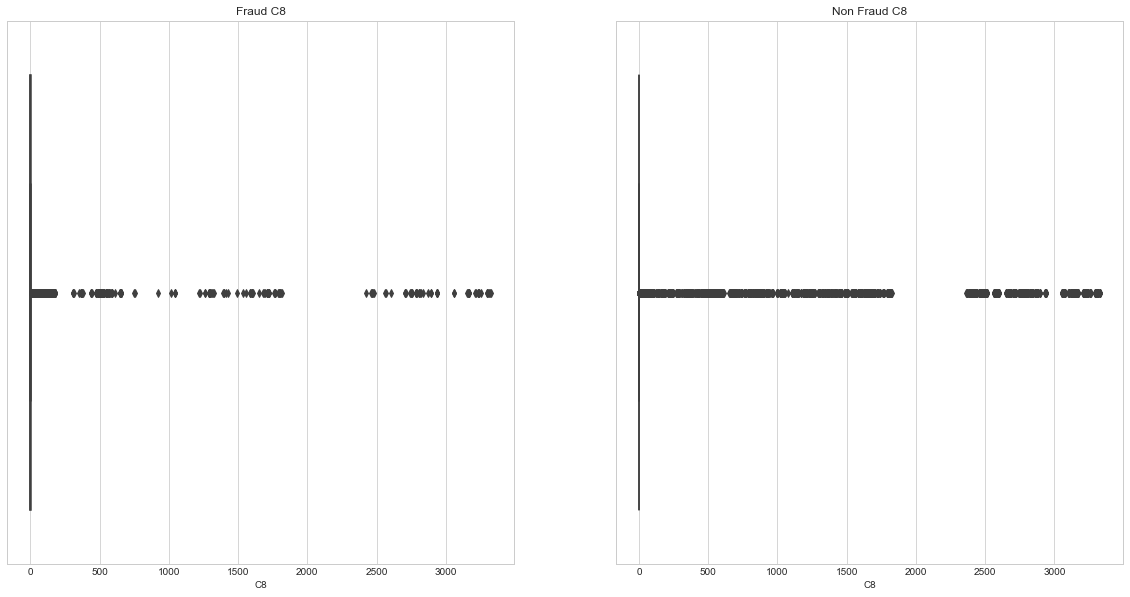

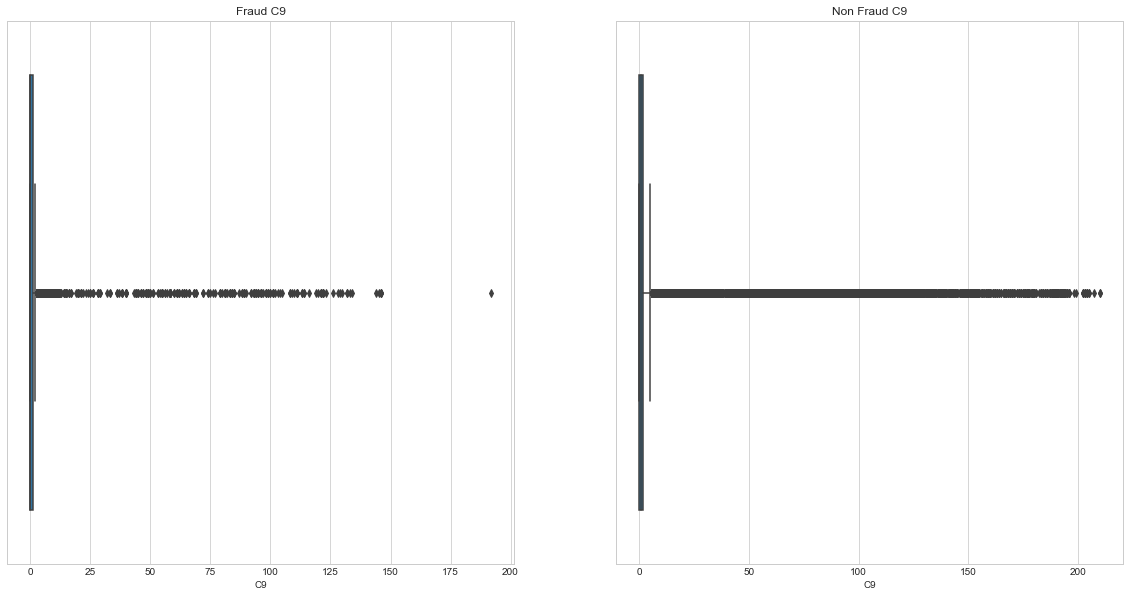

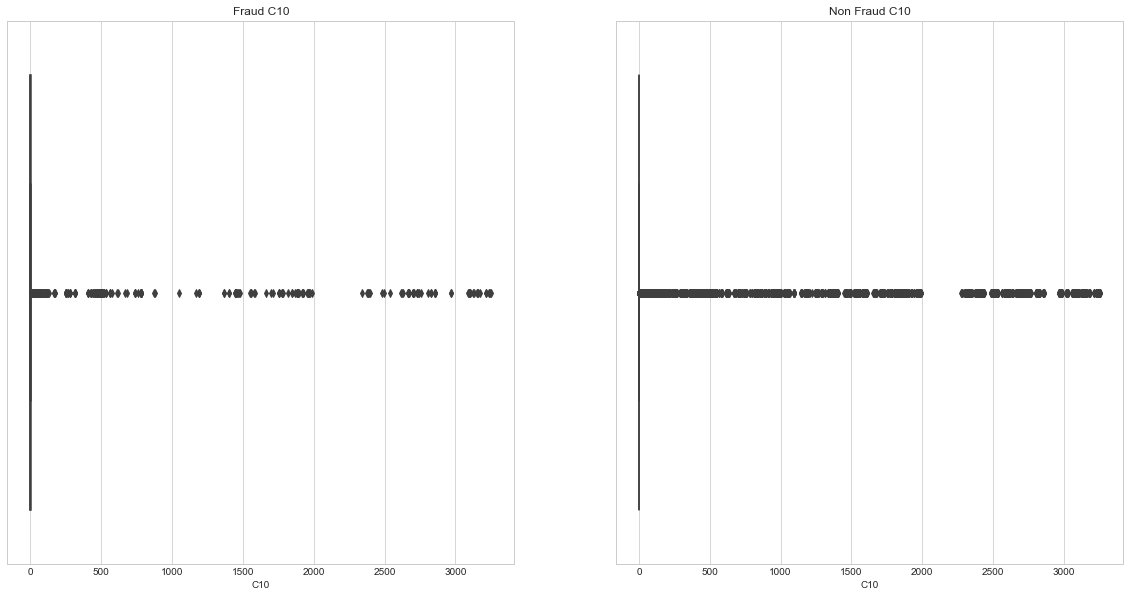

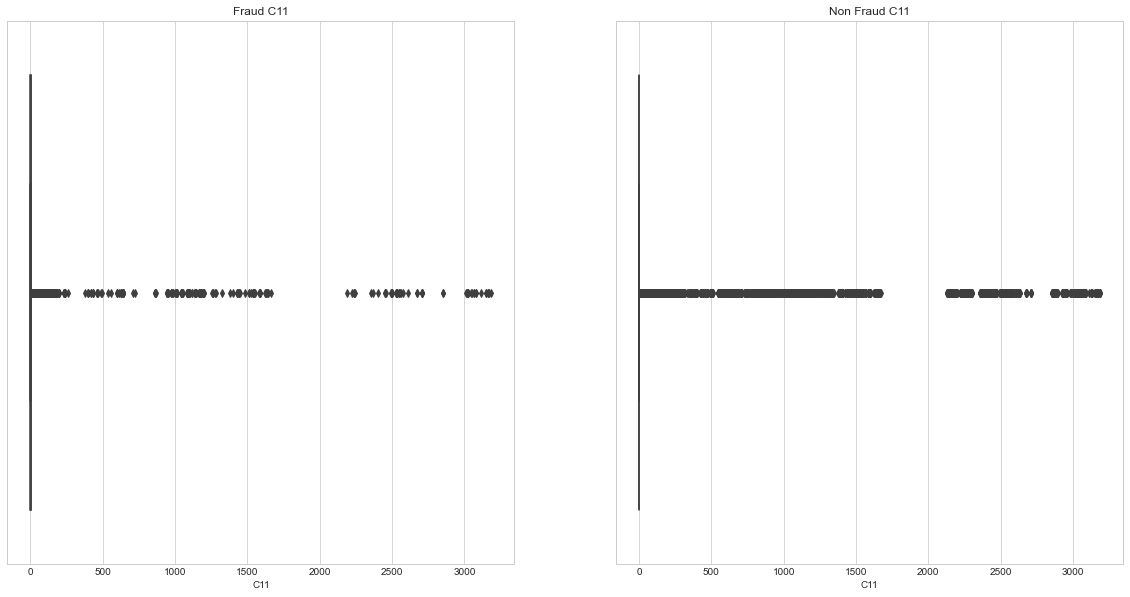

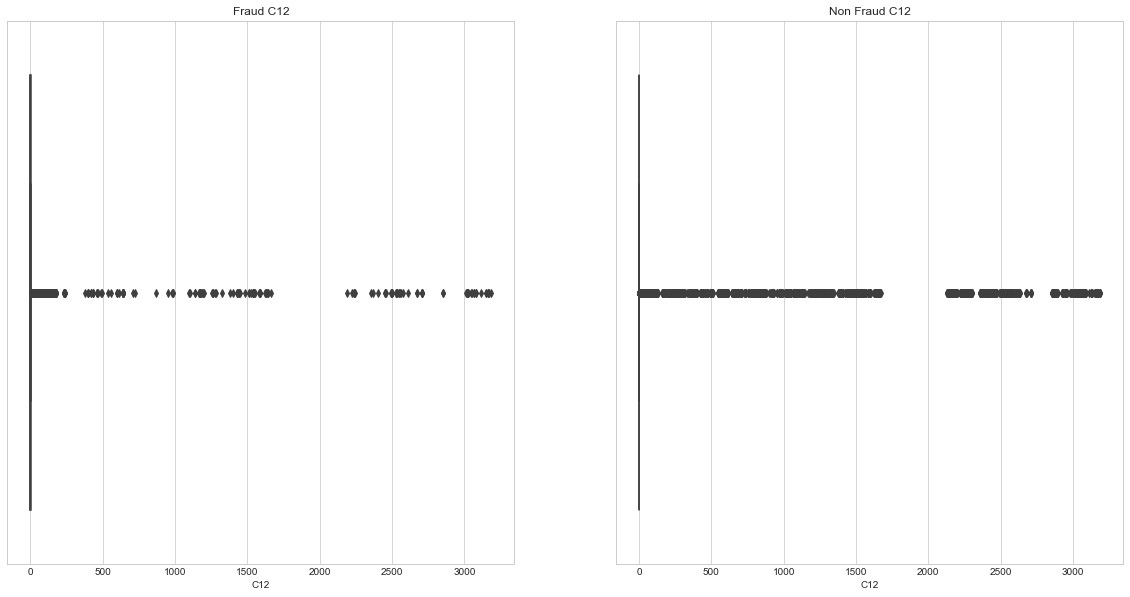

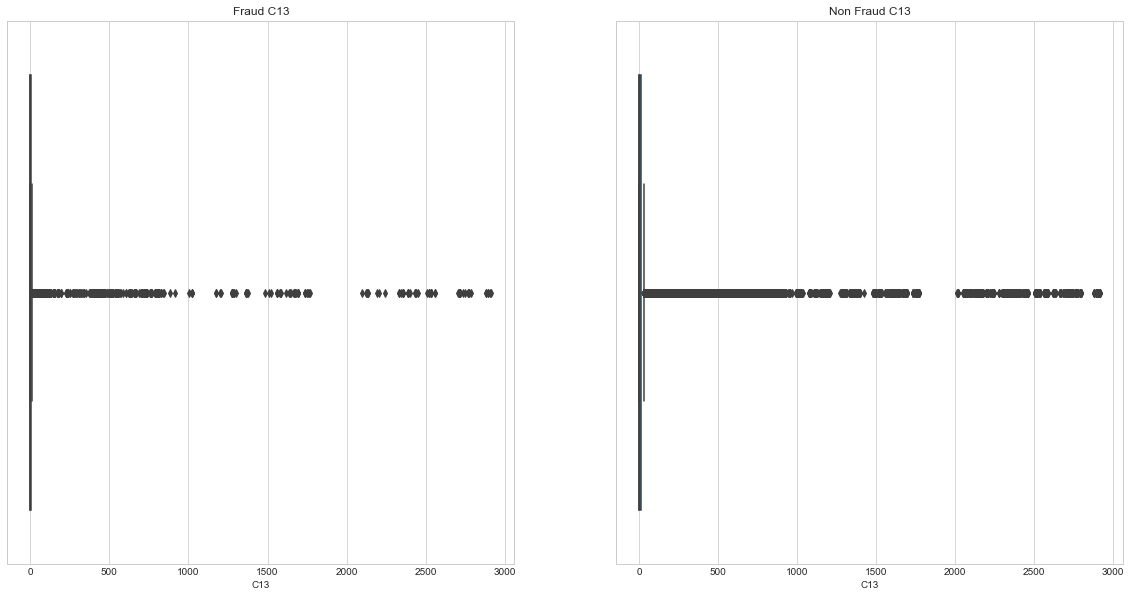

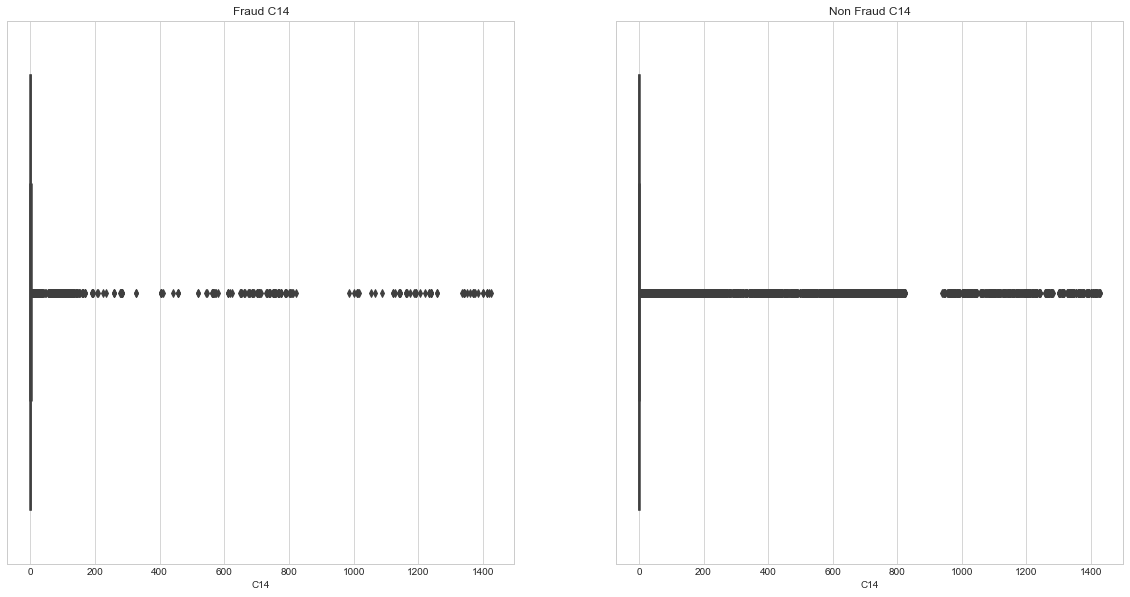

In [36]:
for col in c_cols:
    fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(20,10))
    fraud_df = df_train[df_train['isFraud'] == 1]
    nonfraud_df = df_train[df_train['isFraud'] == 0]
    sns.boxplot(fraud_df[col],ax=axes[0])
    sns.boxplot(nonfraud_df[col],ax=axes[1])
    axes[0].title.set_text(f'Fraud {col}')
    axes[1].title.set_text(f'Non Fraud {col}')
    plt.show()


##  D1-D15

information such as timedelta,ie it can be days between previous transaction, etc.

In [37]:
d_cols = [col for col in df_train.columns if col[0] == 'D' and len(col) <=3]
df_train[d_cols].head()

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15
0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0
1,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0
2,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,315.0
3,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,111.0
4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


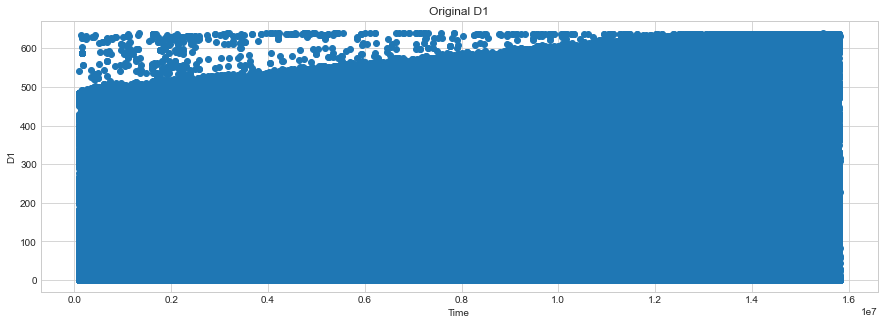

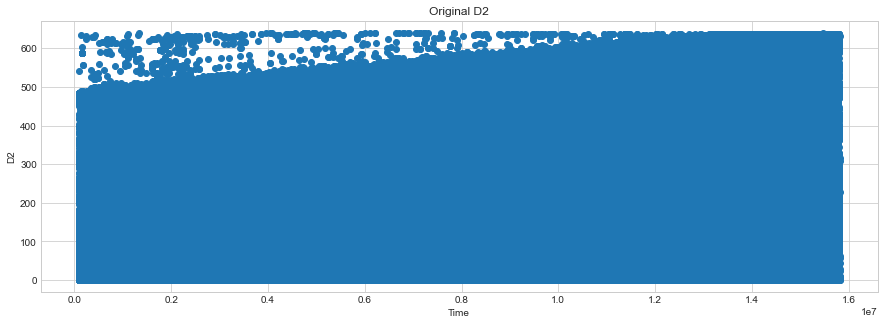

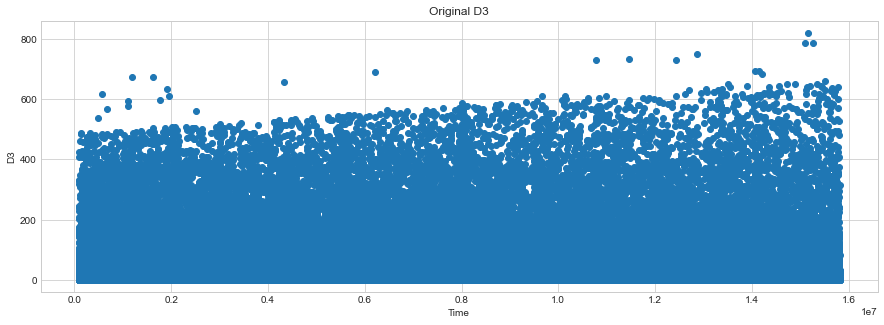

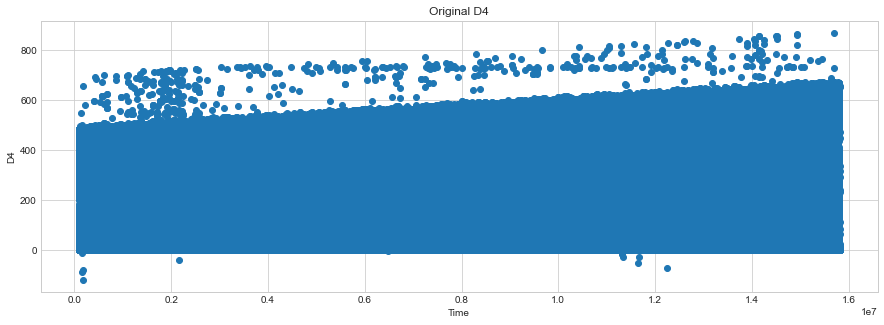

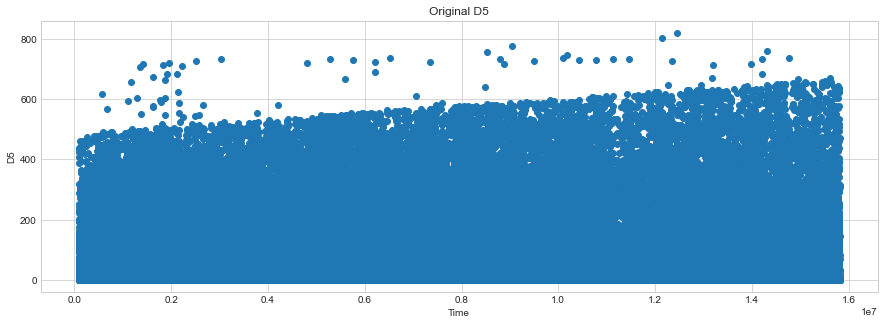

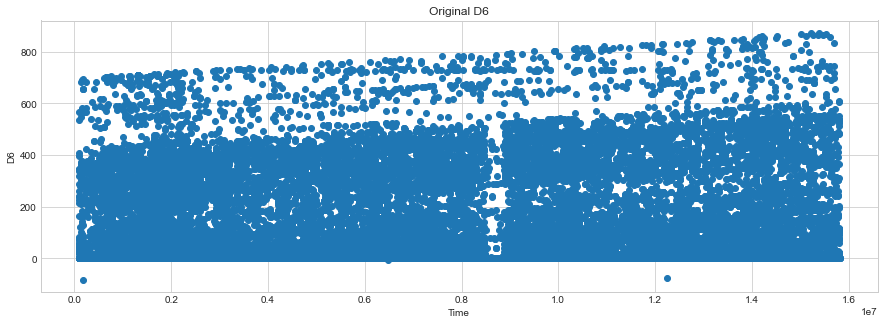

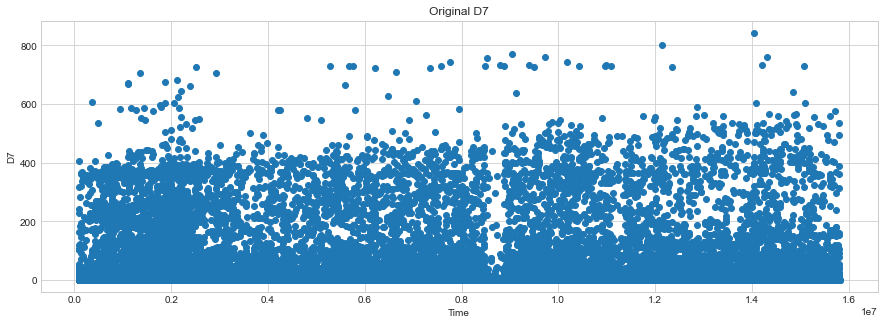

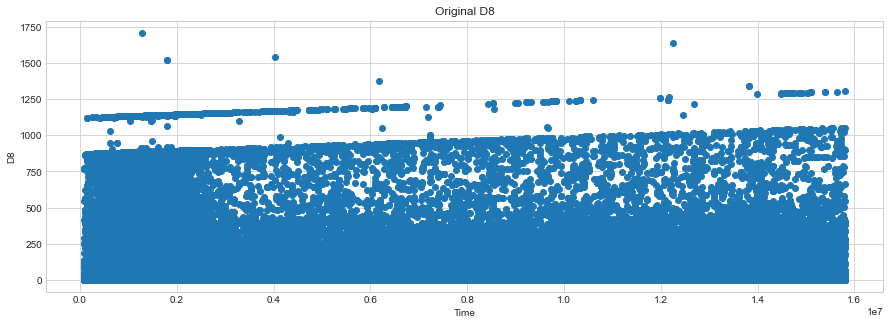

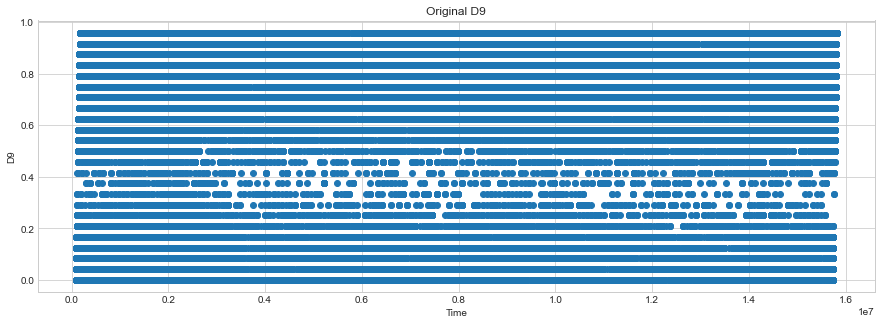

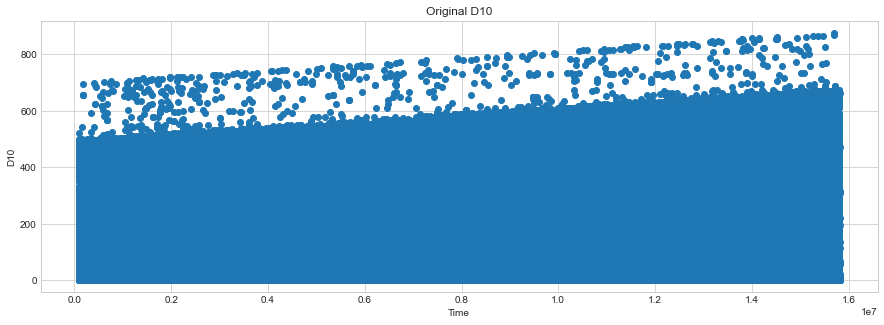

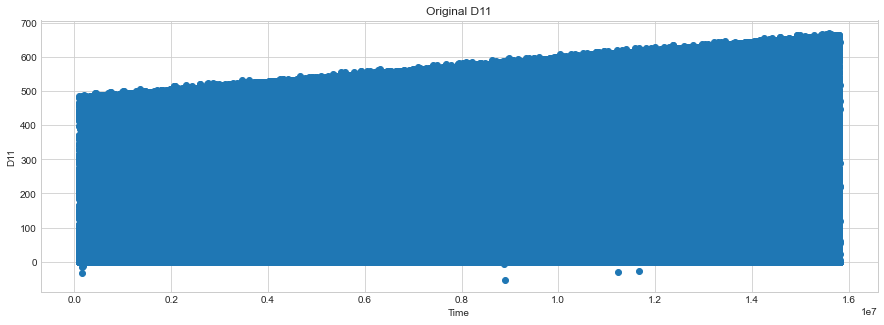

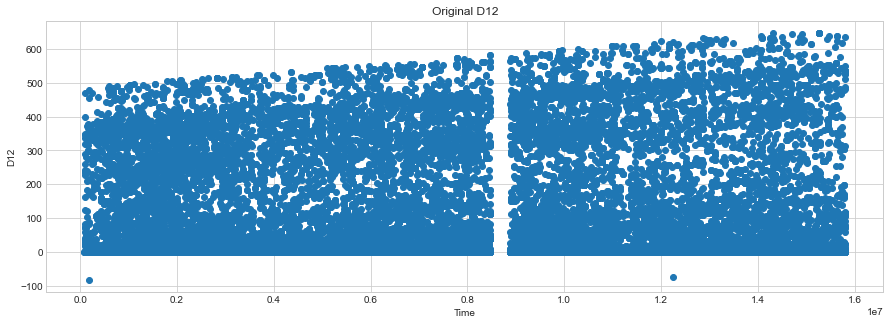

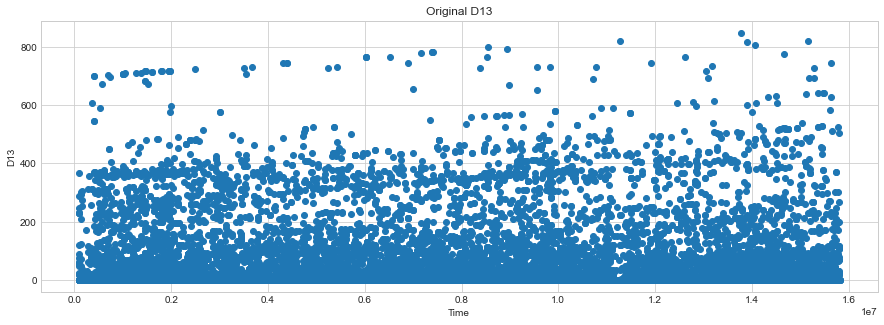

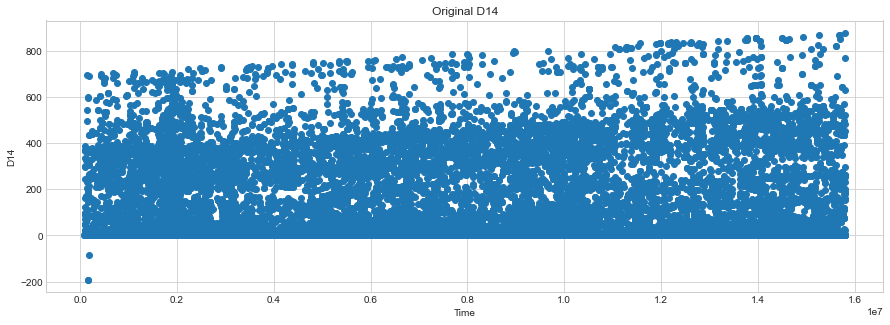

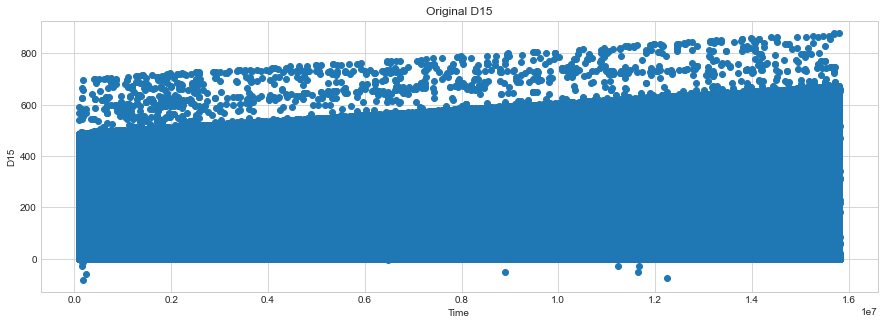

In [38]:
for col in d_cols:
    # PLOT ORIGINAL D
    plt.figure(figsize=(15,5))
    plt.scatter(df_train['TransactionDT'],df_train[col])
    plt.title(f'Original {col}')
    plt.xlabel('Time')
    plt.ylabel(f'{col}')
    plt.show()

### 
D1 is assumed to be days since the client credit card began.Subtracting this value from the “Transaction Day” will result in CONSTANT values per client


Let us see how it looks after normalizing

In [39]:
df_train['D1n'] =  df_train['D1'] - df_train.TransactionDT/np.float32(24*60*60)

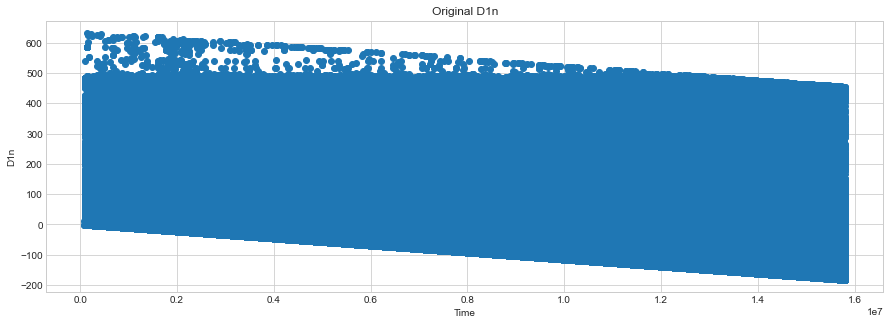

In [40]:
d_cols = ['D1n']
for col in d_cols:
    # PLOT ORIGINAL D
    plt.figure(figsize=(15,5))
    plt.scatter(df_train['TransactionDT'],df_train[col])
    plt.title(f'Original {col}')
    plt.xlabel('Time')
    plt.ylabel(f'{col}')
    plt.show()

## M1-M9

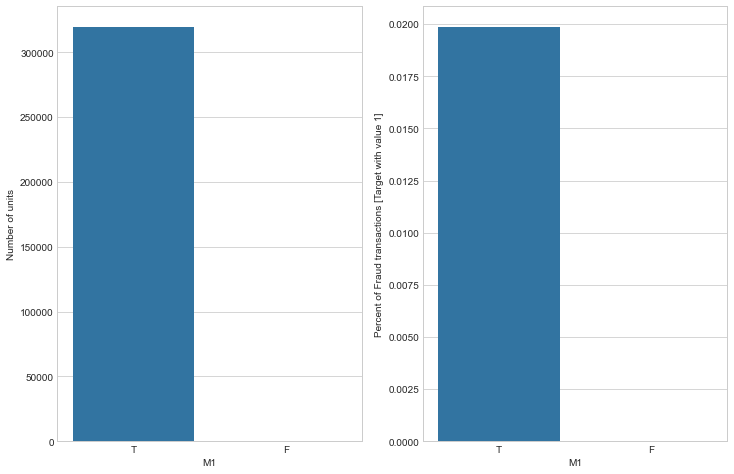

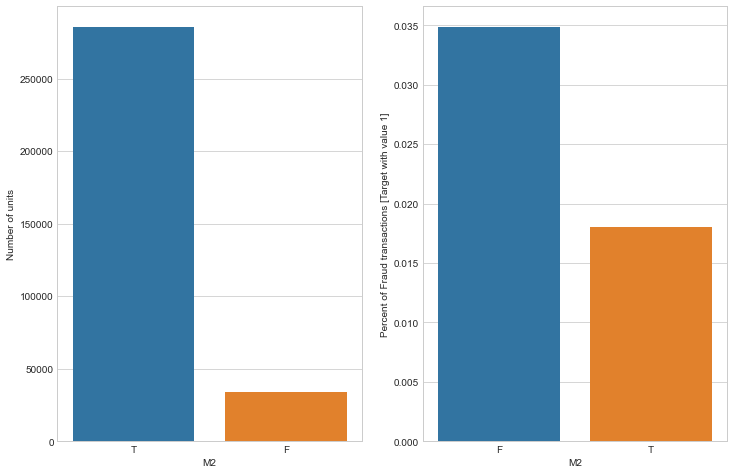

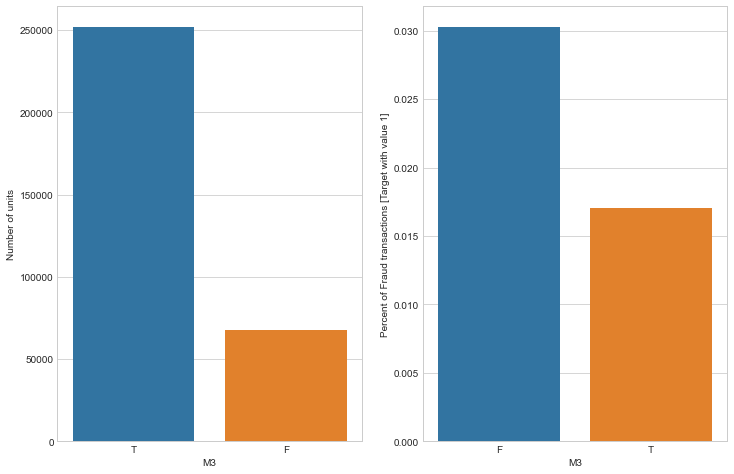

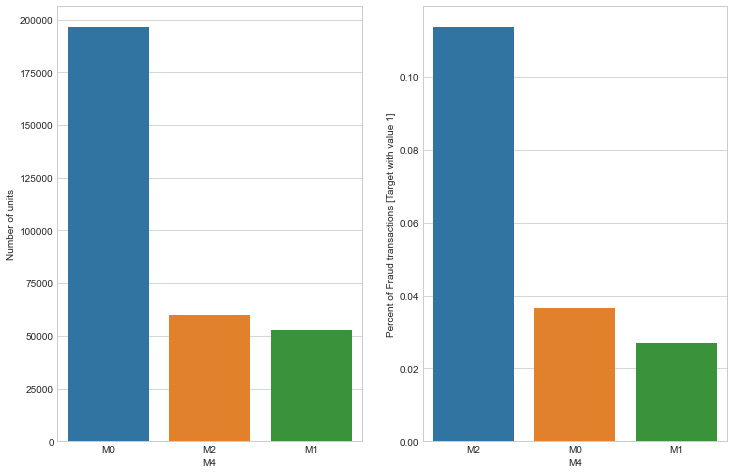

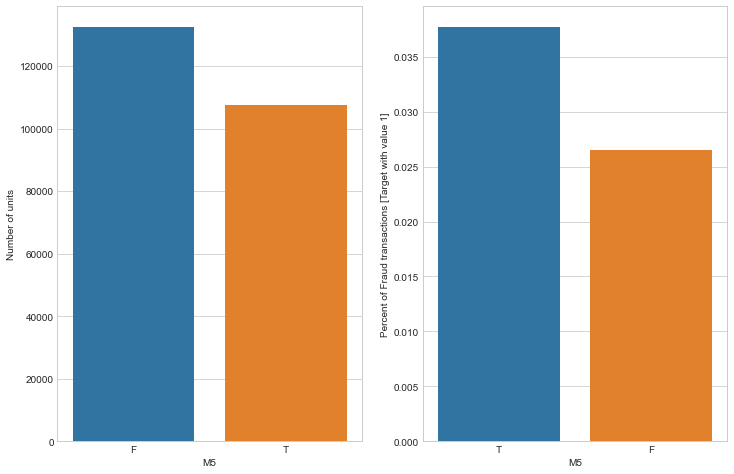

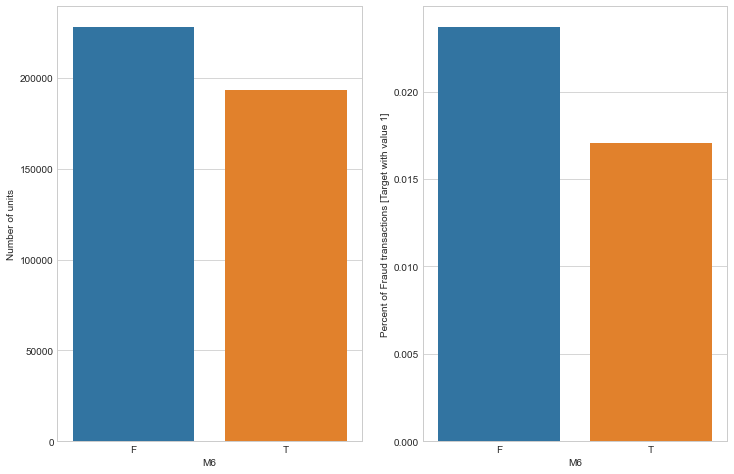

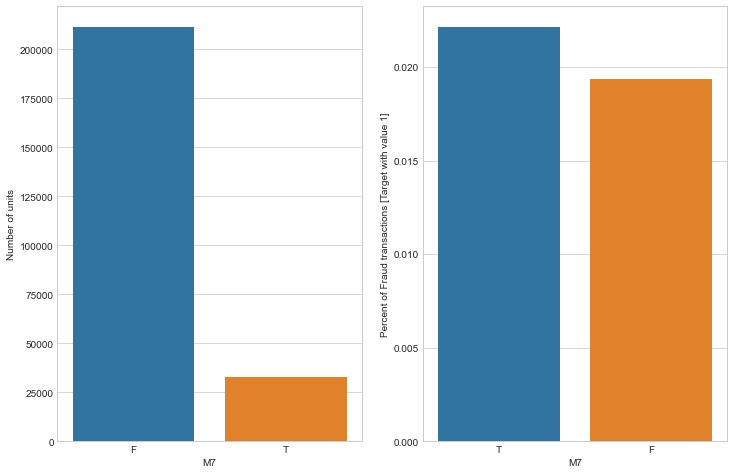

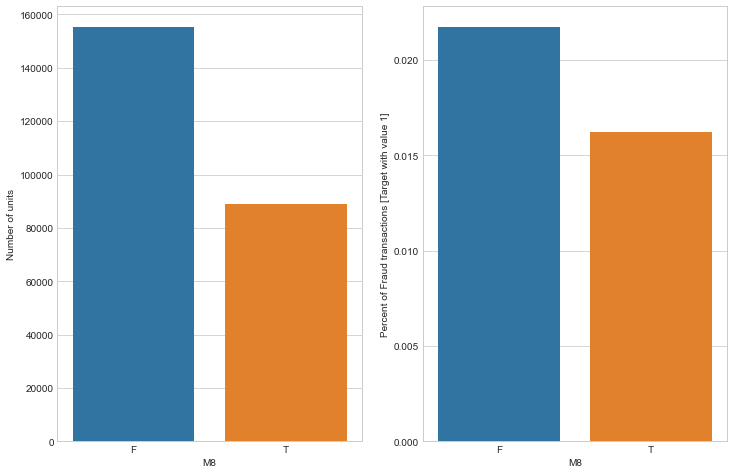

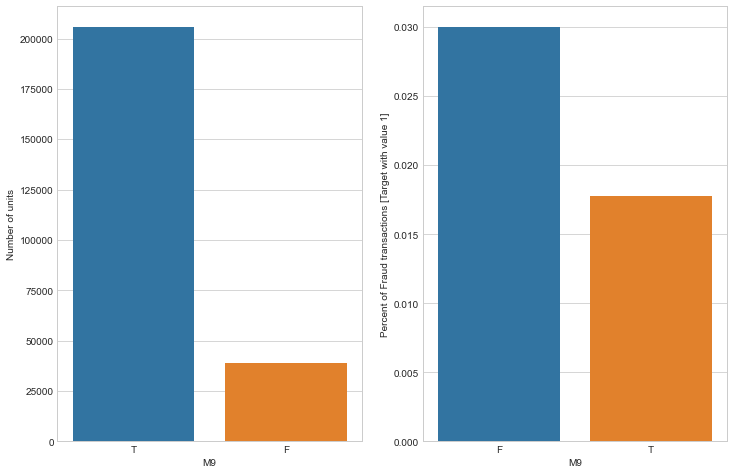

In [41]:
m_cols = [m for m in df_train.columns if m[0] == 'M']

for col in m_cols:
    hor_plot(col)
    plt.show()

###
* In M1 of all cases of T, 2% are fraudulant
* In M2 of all cases of F, 3.5% are fraudulant
* similar readings can be obtained from above graph

# V1 -V399

In [42]:
v_cols = [c for c in df_train if c[0] == 'V']
df_train[v_cols].head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
df_train[v_cols].describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
count,311251.000000,311251.000000,311251.000000,311251.000000,311251.000000,311251.000000,311251.000000,311251.000000,311251.000000,311251.000000,...,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.00000,82351.000000,82351.000000,82351.000000,82351.000000
mean,0.999945,1.045192,1.078062,0.846449,0.876984,1.045680,1.072864,1.027698,1.041523,0.463912,...,0.775874,721.741883,1375.783644,1014.622782,9.807015,59.16455,28.530903,55.352422,151.160542,100.700882
std,0.007390,0.240083,0.320854,0.440045,0.475896,0.239373,0.304771,0.186054,0.226326,0.521522,...,4.727971,6217.223583,11169.275702,7955.735482,243.861391,387.62948,274.576920,668.486833,1095.034387,814.946722
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,25.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
max,1.000000,8.000000,9.000000,6.000000,6.000000,9.000000,9.000000,8.000000,8.000000,4.000000,...,55.000000,160000.000000,160000.000000,160000.000000,55125.000000,55125.00000,55125.000000,104060.000000,104060.000000,104060.000000


## Device type

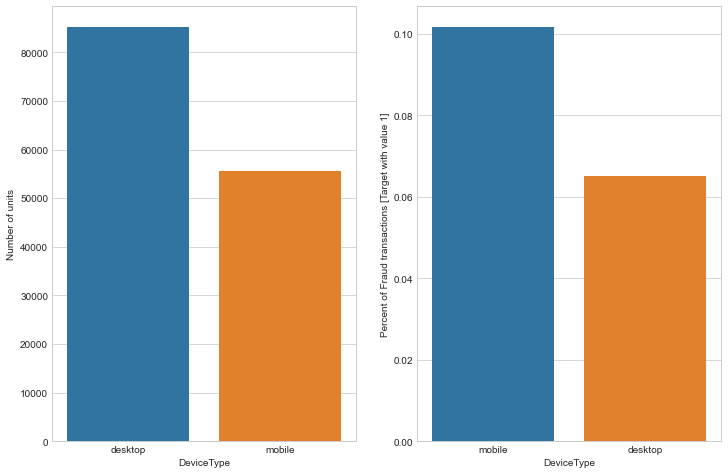

In [44]:
hor_plot('DeviceType',df_train)

### 
* We can see that fraud transaction are mostly made on mobile transactions which is roughly about 10% while only 6.2% fraud in desktop trasactions.

###  Device Info

Information about device used

In [45]:
tmp = df_train[['DeviceInfo','isFraud']].groupby(by=['DeviceInfo']).mean().sort_values(by='isFraud',ascending=False)
print(tmp[tmp['isFraud'] > 0.9].shape)
tmp[tmp['isFraud'] > 0.9]

(49, 1)


,isFraud
DeviceInfo,
ZTE-Z835,1.000000
Dream,1.000000
SM-T285M,1.000000
A5002,1.000000
A466BG,1.000000
SM-T530,1.000000
Blade L3 Build/KOT49H,1.000000
RNE-L23 Build/HUAWEIRNE-L23,1.000000
SAMSUNG-SM-N900A,1.000000


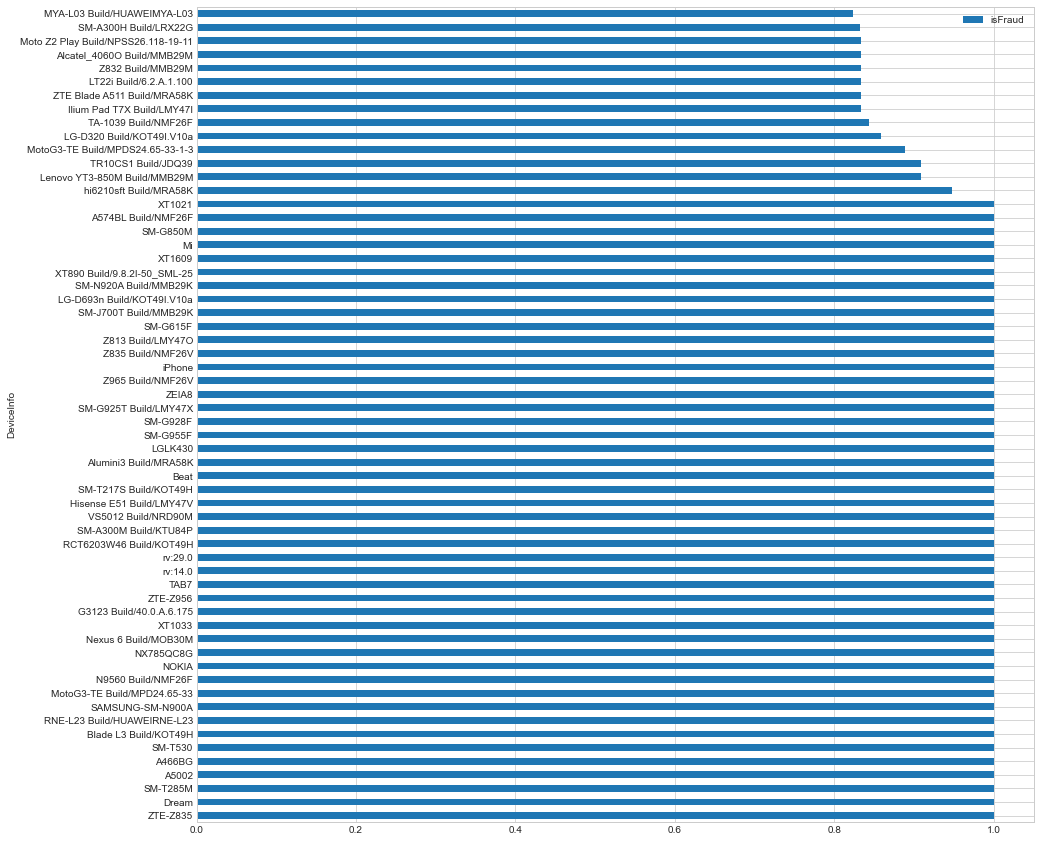

In [46]:
tmp.head(60).plot(kind='barh',figsize=(15, 15))
plt.show()

### 
* We can see that about 49 device information we have chances of being fraud transaction > 90%

###  Id 12 - 38

These are categorical data. It contains network connection information,browser information etc

In [47]:
catid_cols = ['id_'+str(i) for i in range(12,39)]
df_train[catid_cols].head()

,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,...,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,...,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T


### * 
* We will see top fraud cases in each category.

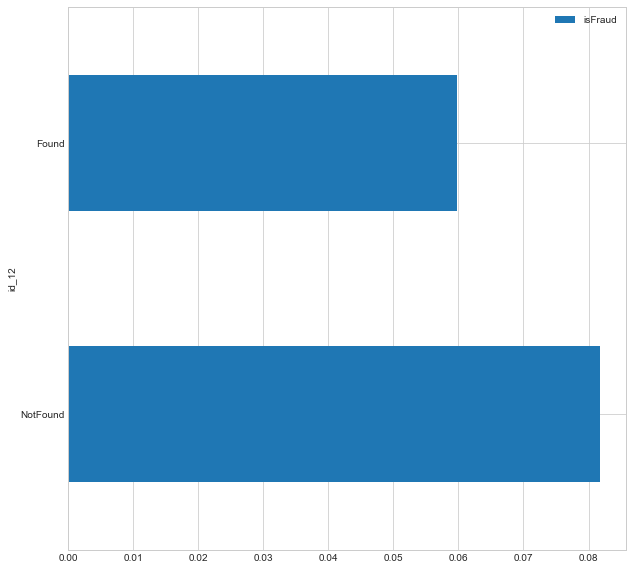

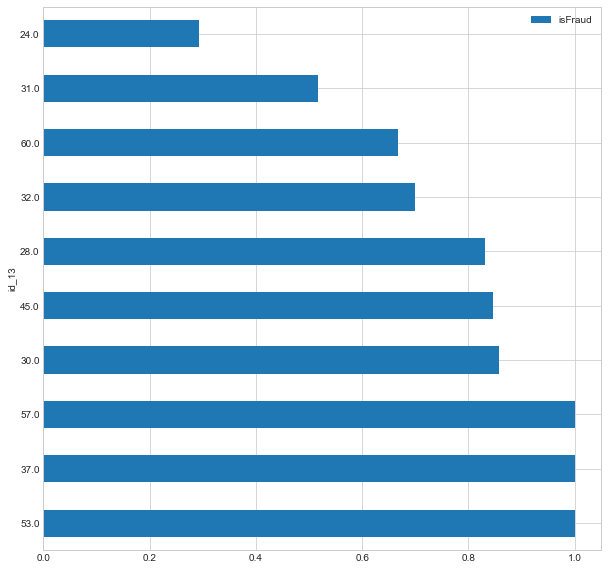

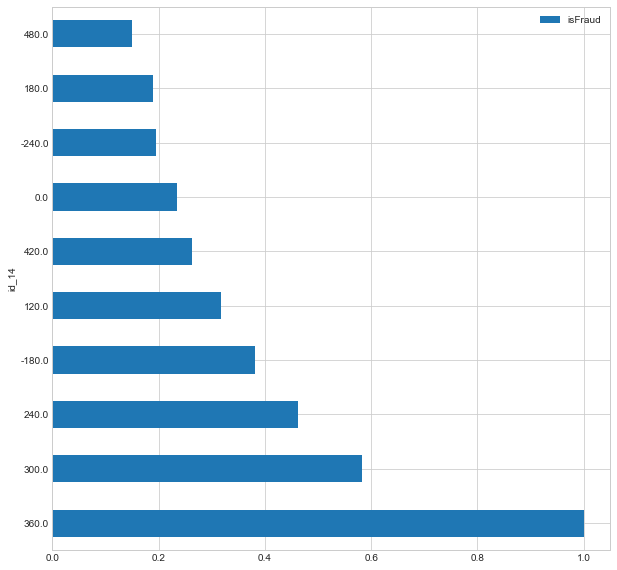

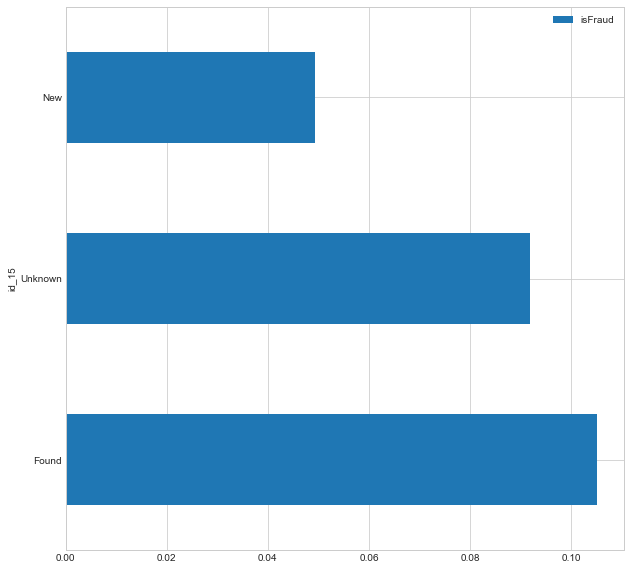

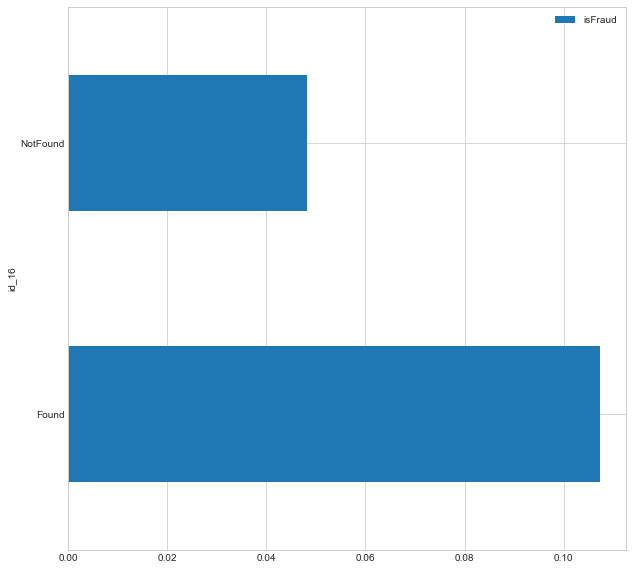

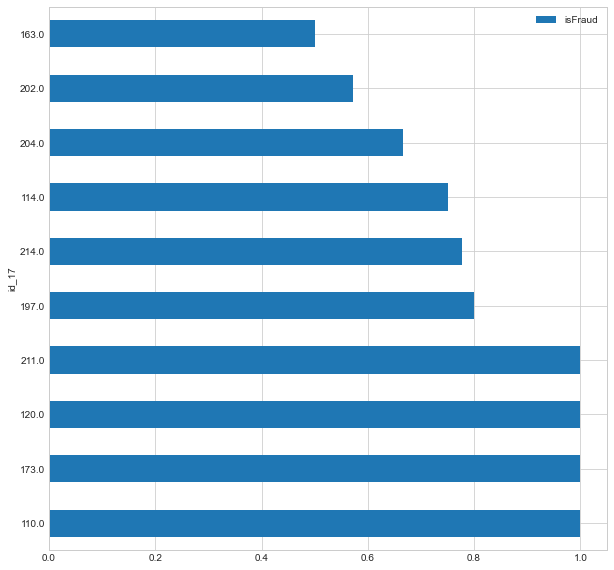

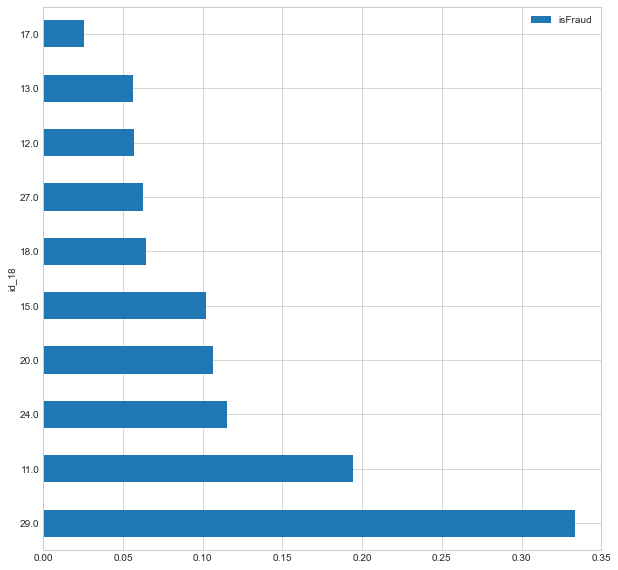

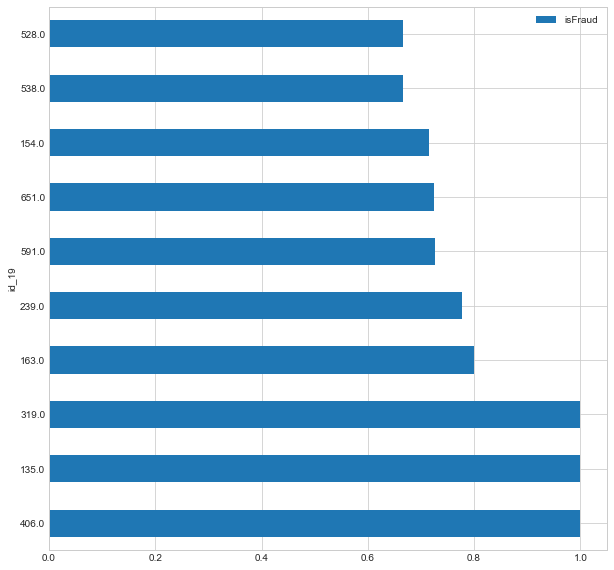

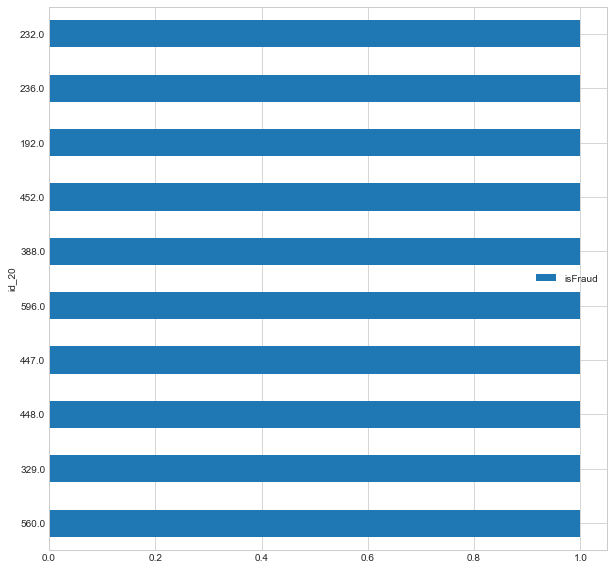

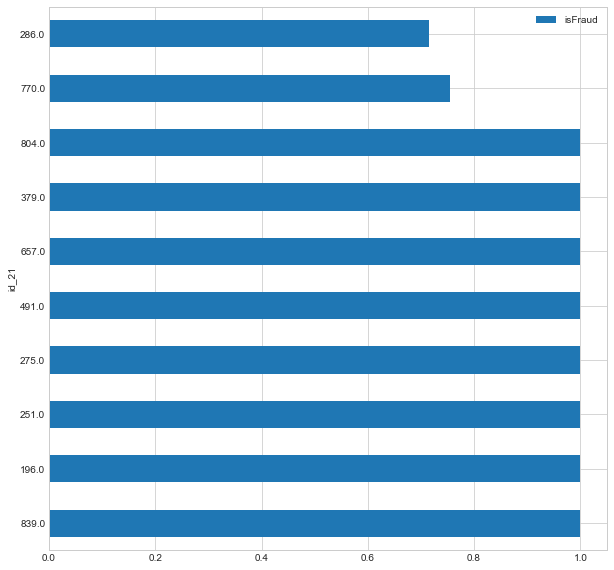

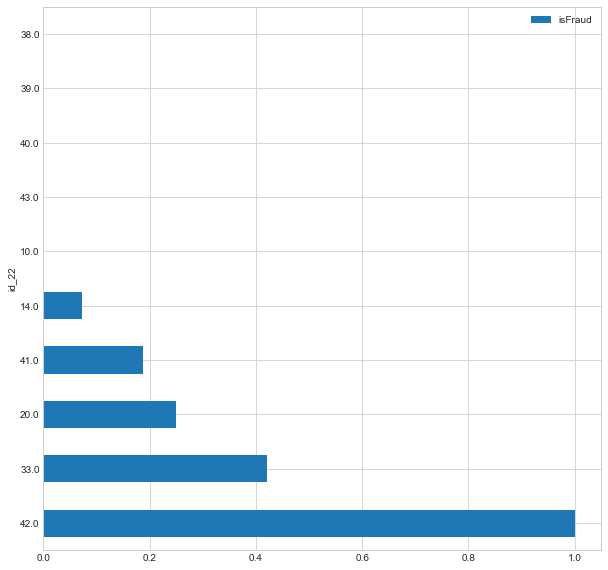

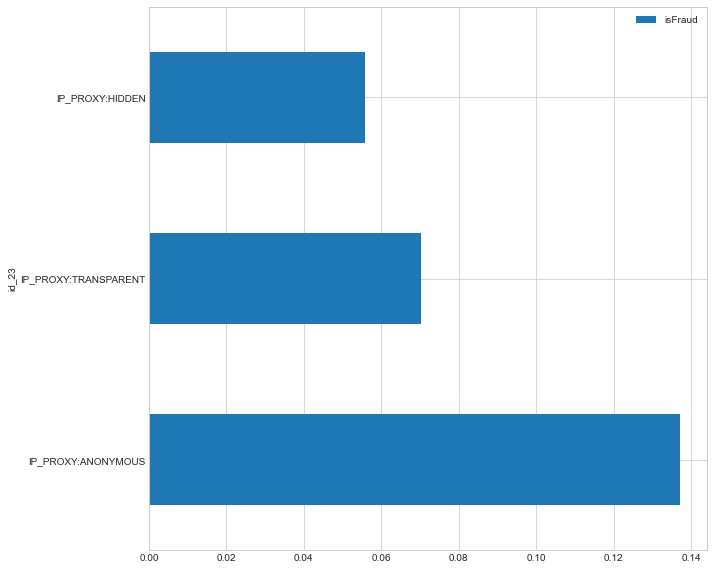

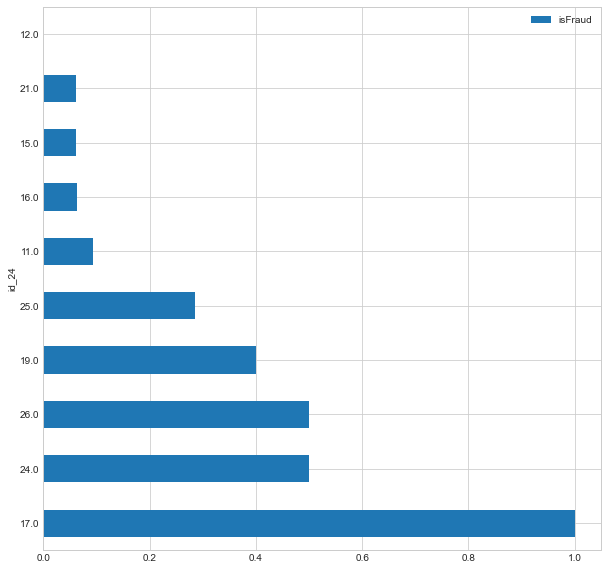

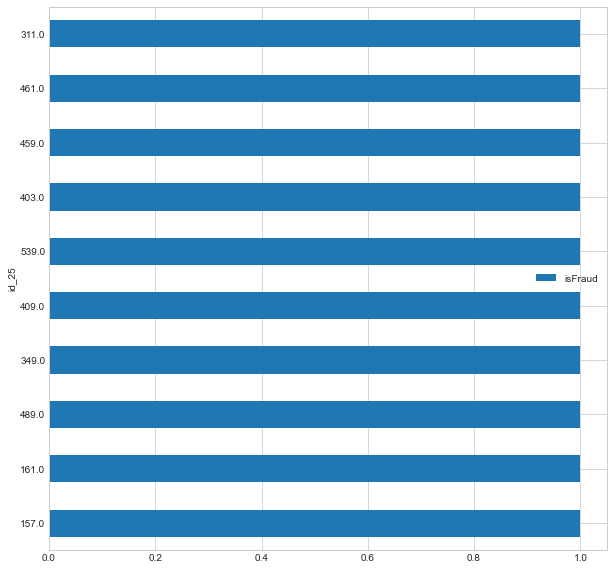

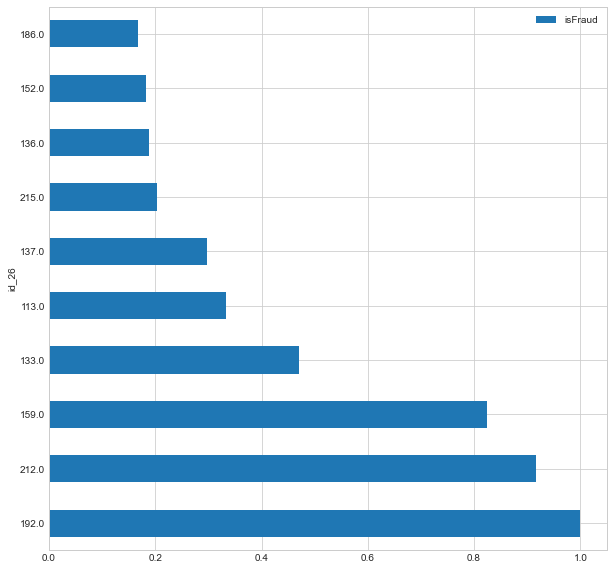

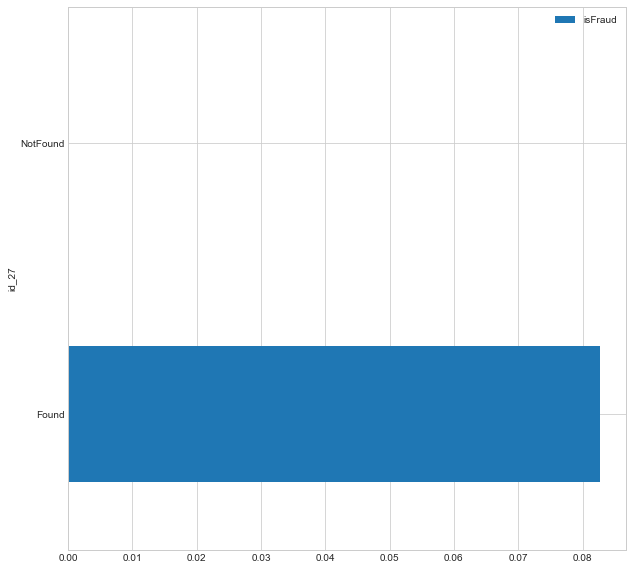

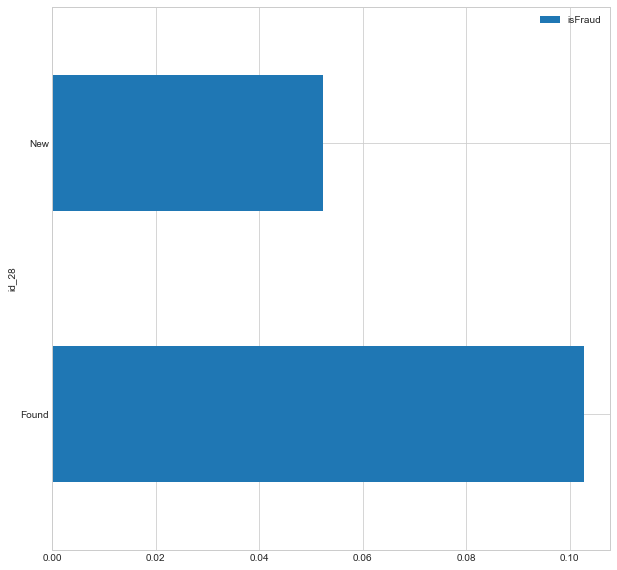

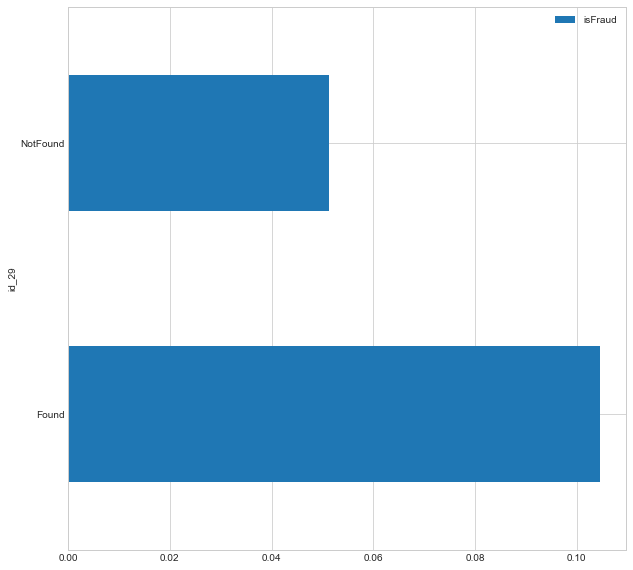

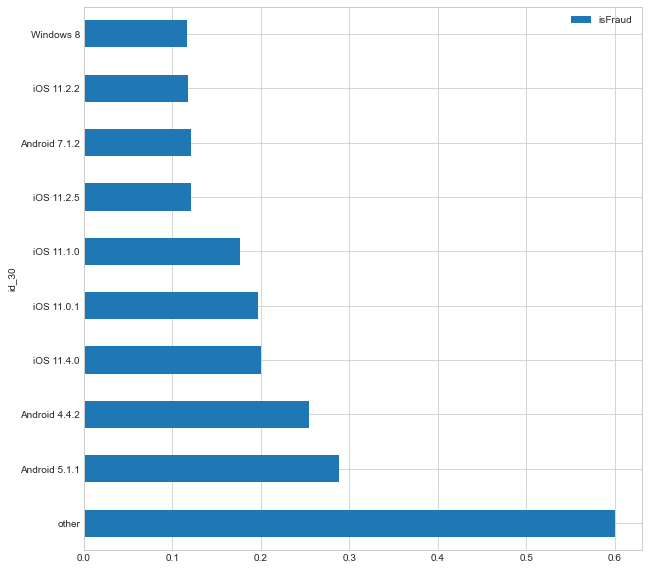

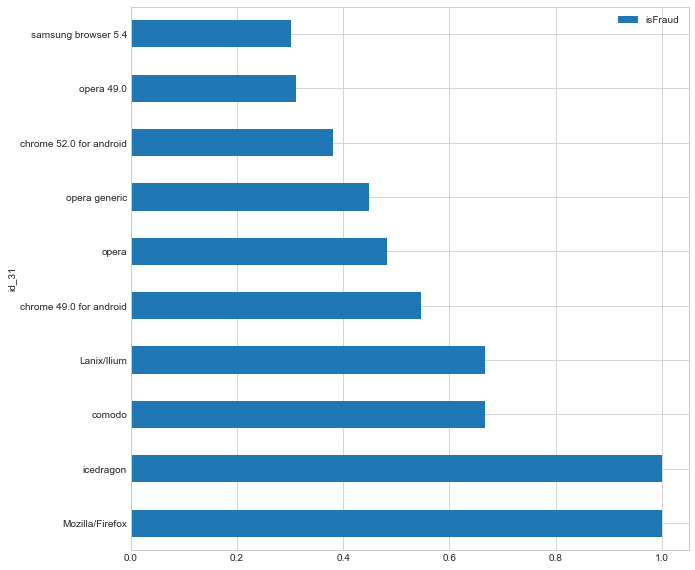

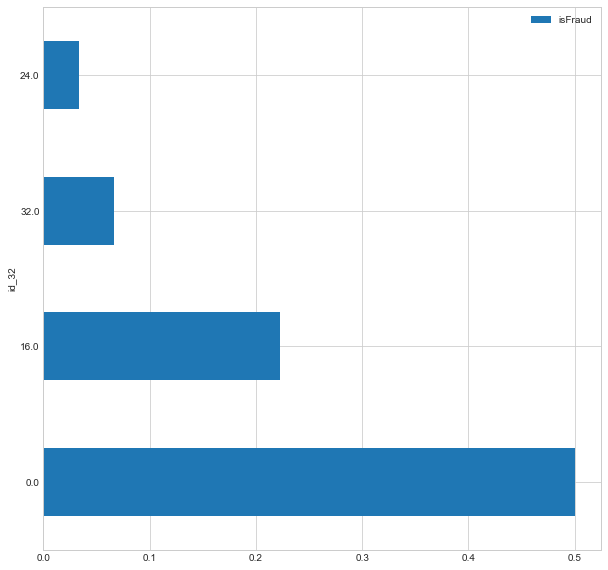

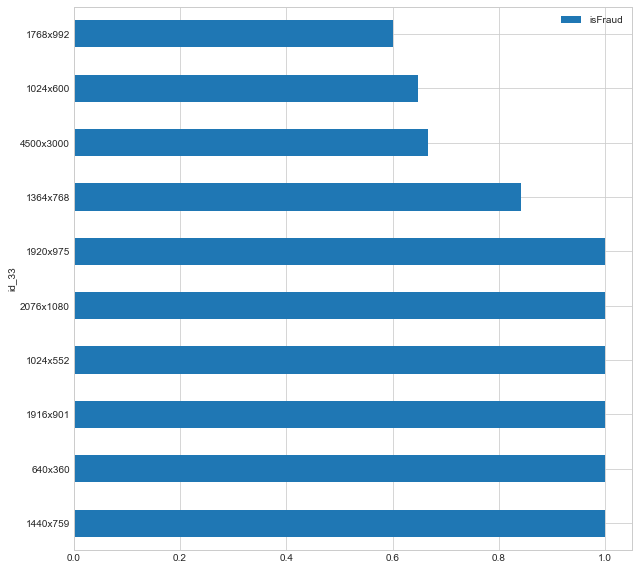

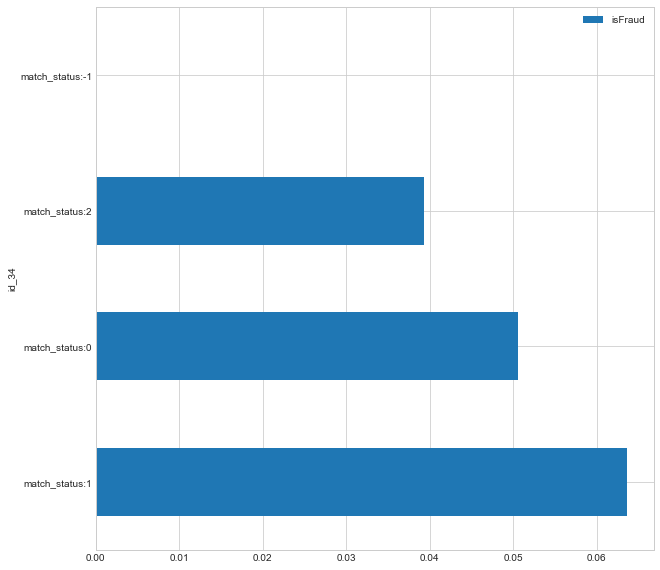

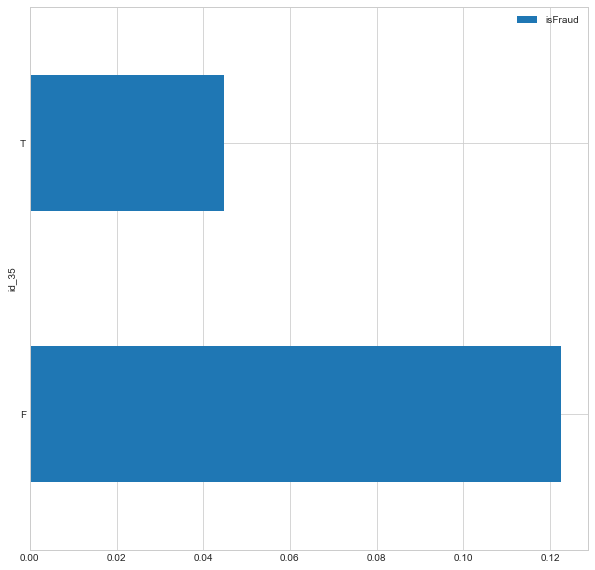

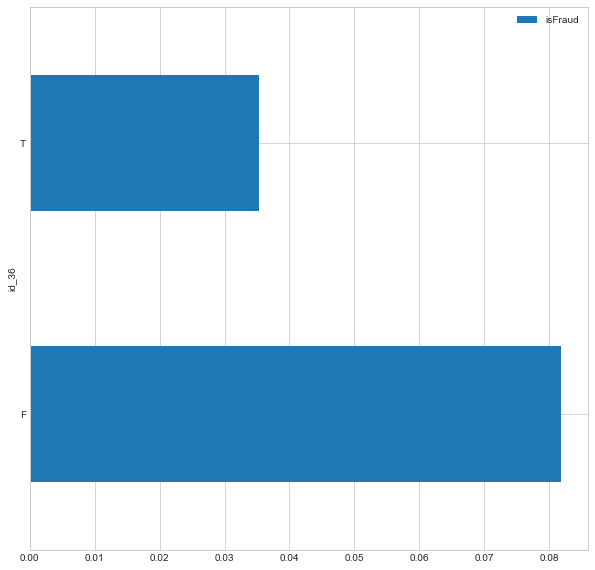

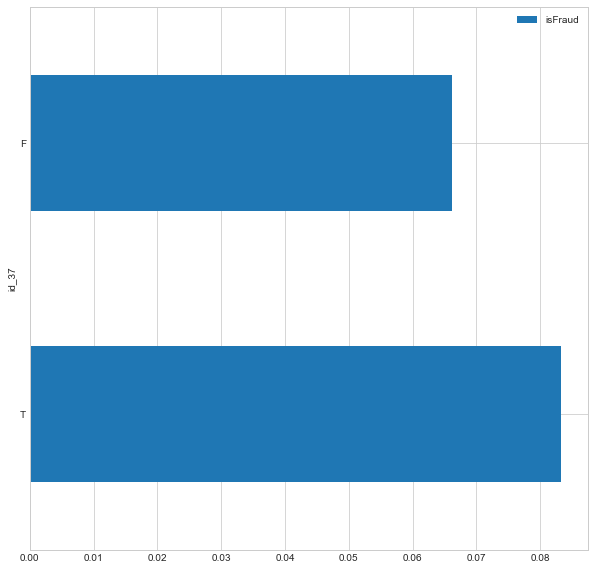

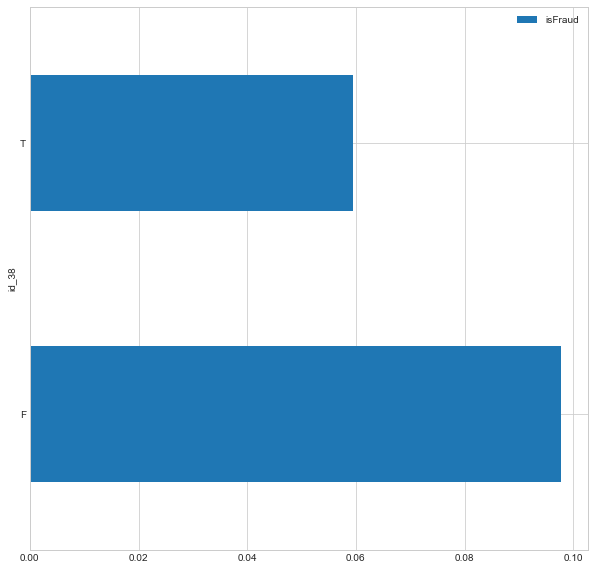

In [48]:
for col in catid_cols:
    df_train[[col,'isFraud']].groupby(by=[col]).mean().sort_values(by=['isFraud'],ascending=False).head(10).\
            plot(kind='barh',figsize=(10, 10))
    plt.show()

In [49]:
print(df_train.shape)
print(df_test.shape)

(590538, 435)
(506691, 433)


In [50]:
# df_train = df_train_transaction.merge(df_train_identity,on=['TransactionID'],how='left')
# df_test = df_test_transaction.merge(df_test_identity,on=['TransactionID'],how='left')
# missing_cols = [col for col in df_train.columns if df_train[col].isnull().sum()/df_train.shape[0] > 0.8]
# req_cols = [col for col in df_train.columns if df_train[col].isnull().sum()/df_train.shape[0] < 0.7]
# df_train = df_train[req_cols]
# req_cols.remove('isFraud')
# df_test = df_test[req_cols]
# print(df_train.shape)
# print(df_test.shape)

## LOGISTIC REGRESSION

In [51]:

X_train = df_train.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)
y_train = df_train.sort_values('TransactionDT')['isFraud']
X_test = df_test.sort_values('TransactionDT').drop(['TransactionDT', 'TransactionID'], axis=1)

print(X_train.shape)
print(X_test.shape)
gc.collect()

(590538, 432)
(506691, 431)


2967

In [52]:
pwd

'C:\\Users\\rahul'

In [53]:
X_train.to_csv(r"C:\Users\rahul\fraudulent transaction detection\data\X_train.csv")
y_train.to_csv(r"C:\Users\rahul\fraudulent transaction detection\data\y_train.csv")